# Chapter 1: Introduction
This chapter covers software installation and testing. We will assume that you have installed Anaconda.




## Installation of Python packages
The following commands will create and actvate the quantum conda environment (assuming you have created one) and installs essential Python packages.
> conda create -n quantum <br>
> conda activate quantum <br>
> conda install python=3.11 <br>
> conda install matplotlib <br>

The following commands will install the necessary packages for D-Wave
> pip install dwave-system <br>
> pip install dwave-neal <br>
> pip install dwave-ocean-sdk <br>
> pip install pyqubo <br>

The following commands will install the necessary packages for Qiskit
> pip install qiskit <br>
> pip install qiskit-ibm-runtime <br>
> pip install qiskit-aer <br>
> pip install ipykernel<br>
> pip install sympy <br>
> pip install pylatexenc <br>
> pip install nbformat <br>


## Test Python environment

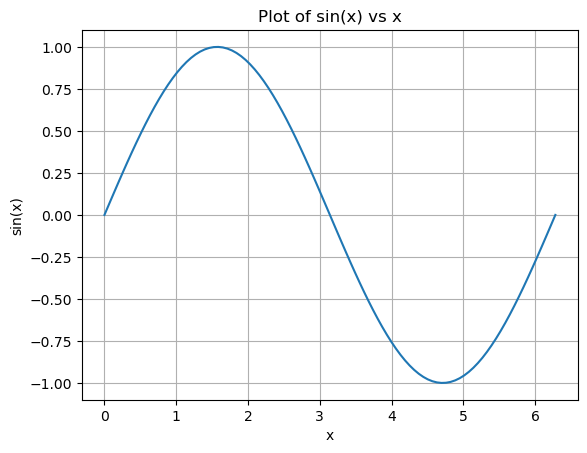

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import math

x = np.linspace(0, 2 * np.pi, 100)
y = np.sin(x)

plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.title('Plot of sin(x) vs x')
plt.grid(True)
plt.show()

## Test the D-Wave installation 
Solve a max-cut graph problem using simulated annealing

In [2]:
import neal
from pyqubo import Binary, Array
import networkx as nx

G = nx.Graph() # graph package
G.add_edges_from([(1,2),(1,3),(2,4),(3,4),(3,5),(4,5)])
H = 0
q = Array.create("q",shape = 5,vartype = "BINARY")
for i, j in G.edges:# create H from graph
    H = H + 2*q[i-1]*q[j-1] - q[i-1] - q[j-1] # offset by 1

model = H.compile()
bqm = model.to_bqm()
sampler = neal.SimulatedAnnealingSampler()
results = sampler.sample(bqm)
print(results)

  q[0] q[1] q[2] q[3] q[4] energy num_oc.
0    1    0    0    1    0   -5.0       1
['BINARY', 1 rows, 1 samples, 5 variables]


## Check Qiskit version

In [3]:
import qiskit
print(qiskit.version.get_version_info())

2.1.2


## Test the Qiskit installation 
Create, simulate and plot a quantum circuit

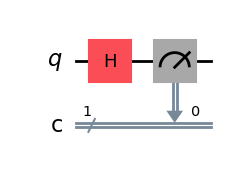

Counts:
 {'1': 479, '0': 521}


In [4]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
import matplotlib.pyplot as plt

circuit = QuantumCircuit(1, 1) 
circuit.h(0) # apply H to qubit 0
# measure and place result in classical bit
circuit.measure(0, 0) 

display(circuit.draw('mpl'))
backend = Aer.get_backend('qasm_simulator')
transpiled_circuit = transpile(circuit, backend)
job = backend.run(transpiled_circuit,shots = 1000)
counts = job.result().get_counts(circuit)
print("Counts:\n",counts)

## Set and save IBM API Token

In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService
QiskitRuntimeService.save_account(channel="ibm_cloud",token="wA5cjkXrgFG-Kc_BlreebN8ZVWnUKMKBXBa0si5dScCS",set_as_default=True, overwrite=True)

## Run on Real Quantum Machine

In [6]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


runOnQuantumHardware = False # set to True to run on Quantum hardware

if (runOnQuantumHardware):
    try:
        service = QiskitRuntimeService()
        backend = service.least_busy(operational=True, simulator=False)
        print(f"Using backend: {backend}")
        circuit = QuantumCircuit(1)
        circuit.h(0)
        circuit.measure_all()
        pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
        isa_circuit = pm.run(circuit) # optimize the circuit for hardware

        # 3. Execute using the Sampler primitive
        sampler = Sampler(mode=backend) 
        job = sampler.run([isa_circuit],shots = 1024)
        pub_result = job.result()[0]
        print(f"Counts: {pub_result.data.meas.get_counts()}")
    except Exception as e:
        print(f"An error occurred: {e}")


## D-Wave Qubit Race

C:\Users\ksure\AppData\Local\Temp\ipykernel_26028\3065110983.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 100000)  # Adjust y-axis for speculative growth


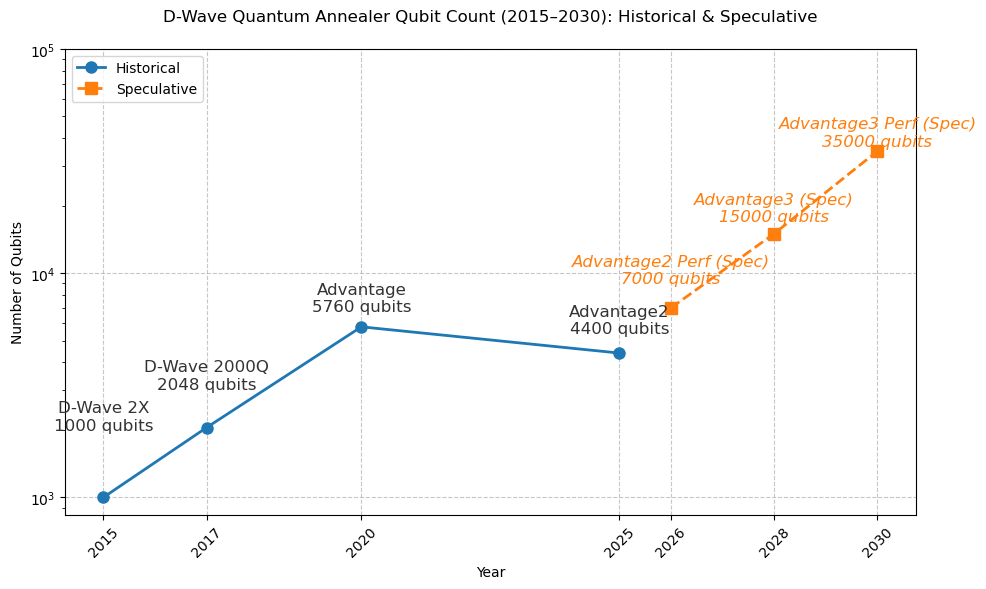

In [7]:
import matplotlib.pyplot as plt

# Historical data (2015–2025)
years_hist = [2015, 2017, 2020, 2025]
qubits_hist = [1000, 2048, 5760, 4400]
models_hist = ['D-Wave 2X', 'D-Wave 2000Q', 'Advantage', 'Advantage2']

# Speculative future data (2026–2030)
years_spec = [2026, 2028, 2030]
qubits_spec = [7000, 15000, 35000]  # Informed estimates based on D-Wave roadmap
models_spec = ['Advantage2 Perf (Spec)', 'Advantage3 (Spec)', 'Advantage3 Perf (Spec)']

# Combine for full timeline
years = years_hist + years_spec
qubits = qubits_hist + qubits_spec
models = models_hist + models_spec
is_spec = [False] * len(years_hist) + [True] * len(years_spec)

# Create the line plot
plt.figure(figsize=(10, 6))
plt.plot(years_hist, qubits_hist, marker='o', linestyle='-', color='#1f77b4', linewidth=2, markersize=8, label='Historical')
plt.plot(years_spec, qubits_spec, marker='s', linestyle='--', color='#ff7f0e', linewidth=2, markersize=8, label='Speculative')

plt.grid(True, linestyle='--', alpha=0.7)

# Add labels for each data point
for i in range(len(years)):
    offset = 1000 if not is_spec[i] else 2000  # Slightly larger offset for future points
    style = 'normal' if not is_spec[i] else 'italic'
    color = '#333333' if not is_spec[i] else '#ff7f0e'
    plt.text(years[i], qubits[i] + offset, f'{models[i]}\n{qubits[i]} qubits', 
             ha='center', fontsize=12, color=color, style=style)

# Customize the plot
plt.title('D-Wave Quantum Annealer Qubit Count (2015–2030): Historical & Speculative', fontsize=12, pad=20)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Number of Qubits', fontsize=10)
plt.xticks(years, rotation=45)  # Rotate for better fit with extended timeline
plt.yscale('log')
plt.ylim(0, 100000)  # Adjust y-axis for speculative growth
plt.legend(loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

## IBM Qubit Race

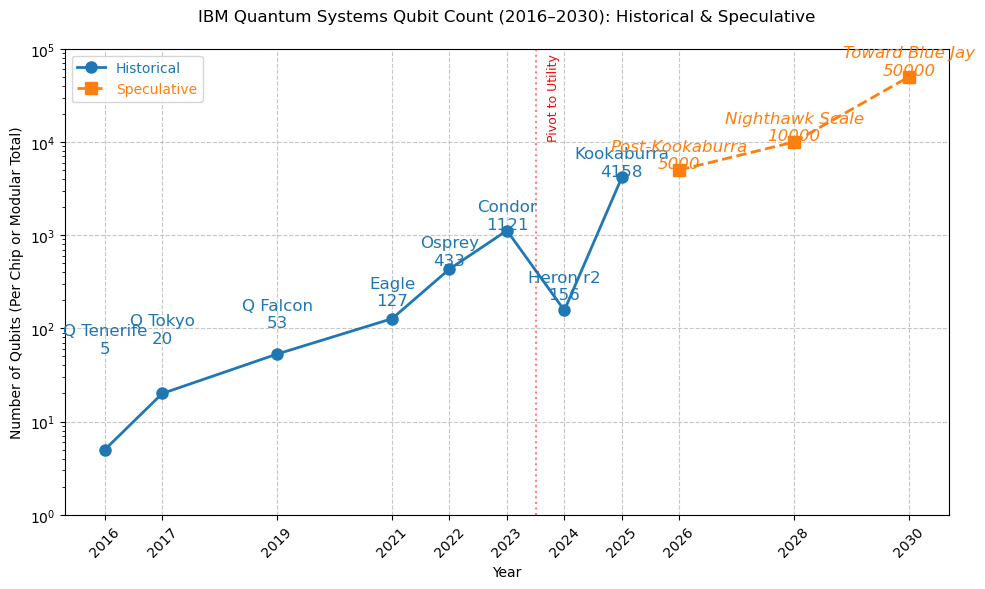

In [8]:
import matplotlib.pyplot as plt

# Historical data (2016–2025)
years_hist = [2016, 2017, 2019, 2021, 2022, 2023, 2024, 2025]
qubits_hist = [5, 20, 53, 127, 433, 1121, 156, 4158]  # Heron at 156; Kookaburra modular total
models_hist = ['Q Tenerife', 'Q Tokyo', 'Q Falcon', 'Eagle', 'Osprey', 'Condor', 'Heron r2', 'Kookaburra']

# Speculative future data (2026–2030)
years_spec = [2026, 2028, 2030]
qubits_spec = [5000, 10000, 50000]  # Post-Kookaburra scaling toward fault-tolerance
models_spec = ['Post-Kookaburra', 'Nighthawk Scale', 'Toward Blue Jay']

# Combine for full timeline
years = years_hist + years_spec
qubits = qubits_hist + qubits_spec
models = models_hist + models_spec
is_spec = [False] * len(years_hist) + [True] * len(years_spec)

# Create the line plot
plt.figure(figsize=(10, 6))
# Single historical line
plt.plot(years_hist, qubits_hist, marker='o', linestyle='-', color='#1f77b4', linewidth=2, markersize=8, label='Historical')
# Speculative line
plt.plot(years_spec, qubits_spec, marker='s', linestyle='--', color='#ff7f0e', linewidth=2, markersize=8, label='Speculative')
# Pivot line
plt.axvline(x=2023.5, color='red', linestyle=':', alpha=0.5, label='Pivot to Utility Focus')
# Text next to pivot line
plt.text(2023.7, 30000, 'Pivot to Utility', color='red', fontsize=9, rotation=90, verticalalignment='center')

# Add labels for data points
for i in range(len(years)):
    offset = max(50, qubits[i] * 0.05)
    style = 'italic' if is_spec[i] else 'normal'
    color = '#ff7f0e' if is_spec[i] else '#1f77b4'
    plt.text(years[i], qubits[i] + offset, f'{models[i]}\n{qubits[i]}', 
             ha='center', fontsize=12, color=color, style=style)

# Customize
plt.title('IBM Quantum Systems Qubit Count (2016–2030): Historical & Speculative', fontsize=12, pad=20)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Number of Qubits (Per Chip or Modular Total)', fontsize=10)
plt.xticks(years, rotation=45)
plt.yscale('log')
plt.ylim(1, 100000)
plt.legend(['Historical', 'Speculative'], loc='upper left', 
           labelcolor=['#1f77b4', '#ff7f0e'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

# Chapter 2: Quantum Annealing Strategy

Simulated annealing and quantum annealing are heuristic algorithms to solve quadratic unconstrained binary optimization (QUBO) problems, that are extremely difficult to solve using deterministic algorithms. Simulated annealing algorithms are executed on classical computers, while quantum annealing algorithms are executed on quantum machines such as the D-Wave  with several thousand qubits. 

## Import Modules for Solving QUBO

In [9]:
from pyqubo import Binary, Array,Placeholder
from dimod.reference.samplers import ExactSolver
import neal
from dwave.system import LeapHybridSampler, DWaveSampler, EmbeddingComposite
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

##  Pose and solve a 3-variable QUBO problem using an exact solver.

$$ \min_{\{a,b,c\}}  (0.6 a b +0.2 a c + 0.03 b c - 0.1 a - 0.5 b - 0.2c ) $$

In [10]:
a,b,c = Binary("a"), Binary("b"),Binary("c")
H  = 0.6*a*b +0.2*a*c + 0.03*b*c -0.1*a - 0.5*b -0.2*c
model = H.compile()
bqm = model.to_bqm()
# using exact solver for small problems
sampler = ExactSolver() 
results = sampler.sample(bqm)
print(results)

   a  b  c energy num_oc.
6  0  1  1  -0.67       1
7  0  1  0   -0.5       1
1  0  0  1   -0.2       1
2  1  0  1   -0.1       1
3  1  0  0   -0.1       1
0  0  0  0    0.0       1
4  1  1  0    0.0       1
5  1  1  1   0.03       1
['BINARY', 8 rows, 8 samples, 3 variables]


## Max-cut graph QUBO problem using Exact solver

In [11]:
G = nx.Graph() # convenient
G.add_edges_from([(1,2),(1,3),(2,4),(3,4),(3,5),(4,5)])
H = 0
q = Array.create("q",shape = 5,vartype = "BINARY")
for i, j in G.edges:# create H from graph
    H = H + 2*q[i-1]*q[j-1] - q[i-1] - q[j-1] # offset by 1

model = H.compile()
bqm = model.to_bqm()
# using exact solver for small problems
sampler = ExactSolver()  
results = sampler.sample(bqm)
print(results)

   q[0] q[1] q[2] q[3] q[4] energy num_oc.
8     1    0    0    1    0   -5.0       1
9     1    0    0    1    1   -5.0       1
28    0    1    1    0    0   -5.0       1
29    0    1    1    0    1   -5.0       1
6     1    0    0    0    1   -4.0       1
11    1    0    1    1    0   -4.0       1
12    0    0    1    1    0   -4.0       1
19    0    1    1    1    0   -4.0       1
25    1    1    0    0    1   -4.0       1
30    0    1    0    0    1   -4.0       1
2     0    0    1    0    1   -3.0       1
3     0    0    1    0    0   -3.0       1
4     1    0    1    0    0   -3.0       1
5     1    0    1    0    1   -3.0       1
14    0    0    0    1    1   -3.0       1
15    0    0    0    1    0   -3.0       1
16    0    1    0    1    0   -3.0       1
17    0    1    0    1    1   -3.0       1
22    1    1    0    1    1   -3.0       1
23    1    1    0    1    0   -3.0       1
26    1    1    1    0    1   -3.0       1
27    1    1    1    0    0   -3.0       1
1     0    

##  Solve using Simulated Annealing

In [12]:
sampler = neal.SimulatedAnnealingSampler()
results = sampler.sample(bqm)
print(results)

  q[0] q[1] q[2] q[3] q[4] energy num_oc.
0    1    0    0    1    0   -5.0       1
['BINARY', 1 rows, 1 samples, 5 variables]


##  Solve a constrained graph problem 
Via the Lagrangian multiplier, using an Exact QUBO solver.

In [13]:
G = nx.Graph() # convenient
G.add_edges_from([(1,2),(1,3),(2,4),(3,4),(3,5),(4,5)])
H = 0
q = Array.create("q",shape = 5,vartype = "BINARY")
for i, j in G.edges:# create H from graph
    H = H + 2*q[i-1]*q[j-1] - q[i-1] - q[j-1] # offset by 1
lam = 100
H = H + lam*(q[0] + q[3]-1)**2
model = H.compile()
bqm = model.to_bqm()
# using exact solver for small problems
sampler = ExactSolver()  
results = sampler.sample(bqm)
print(results)

   q[0] q[1] q[2] q[3] q[4] energy num_oc.
4     0    0    1    1    0   -4.0       1
14    1    0    0    0    1   -4.0       1
17    1    1    0    0    1   -4.0       1
27    0    1    1    1    0   -4.0       1
2     1    0    1    0    0   -3.0       1
7     0    0    0    1    0   -3.0       1
8     0    0    0    1    1   -3.0       1
13    1    0    1    0    1   -3.0       1
18    1    1    1    0    1   -3.0       1
23    0    1    0    1    1   -3.0       1
24    0    1    0    1    0   -3.0       1
29    1    1    1    0    0   -3.0       1
1     1    0    0    0    0   -2.0       1
11    0    0    1    1    1   -2.0       1
20    0    1    1    1    1   -2.0       1
30    1    1    0    0    0   -2.0       1
6     1    0    0    1    0   95.0       1
9     1    0    0    1    1   95.0       1
19    0    1    1    0    1   95.0       1
28    0    1    1    0    0   95.0       1
5     1    0    1    1    0   96.0       1
16    0    1    0    0    1   96.0       1
3     0    

## QUBO Box Solver
The Box algorithm to solve a linear system of equations.

In [14]:
class QUBOBoxSolverClass:
	def __init__(self,beta=0.5,LBox0 = 1,tol = 1e-6,
			  samplingMethod = "simulatedAnnealing", 
			  nSamples = 50,boxMaxIteration = 100):	
		
		self.beta = beta
		self.LBox0 = LBox0
		self.boxMaxIteration = boxMaxIteration
		self.relativeTolerance = tol
		self.samplingMethod = samplingMethod #  exact, simulatedAnnealing, quantumAnnealing
		self.nSamples = nSamples # not relevant for symbolic sampling method
		if (self.samplingMethod == "exact"):
			self.sampler = ExactSolver()
		elif (self.samplingMethod == "simulatedAnnealing"):
			self.sampler = neal.SimulatedAnnealingSampler(); #SimulatedAnnealingSampler()
		elif (self.samplingMethod == "hybridQuantumAnnealing"):
			self.sampler = LeapHybridSampler()       
		elif (self.samplingMethod == "quantumAnnealing"):
			self.sampler = EmbeddingComposite(DWaveSampler())      
		else:
			print("Invalid sampling method")

		self.nQubitsPerDimension = 2 # don't change
		
	def modelWithPlaceHolders(self):
		# When using PyQUBO, creating a self.model with place holers avoids repeated compiling
		q = self.matrixSize*[None]
		for i in range(self.matrixSize):
			q[i] = Array.create("q[" + str(i)+"]",shape = self.nQubitsPerDimension,vartype = "BINARY")
		c = self.matrixSize*[0]#placeholders
		b = self.matrixSize*[0]#placeholders
		A = self.matrixSize*[0]#placeholders
		x = self.matrixSize*[0]# symbolic via qubits  
		for i in range(self.matrixSize):
			A[i] = self.matrixSize*[0]#placeholders		  
		L = Placeholder('L')
		for i in range(self.matrixSize):
			c[i] = Placeholder('c[%d]' %i)
			b[i] = Placeholder('b[%d]' %i)
			for j in range(self.matrixSize):
				A[i][j] = Placeholder("A[{i}][{j}]".format(i = i, j = j))      
		for i in range(self.matrixSize):
			x[i] = c[i] + L*(-2*q[i][0] + q[i][1])
		   
		H = 0
		for  i in range(self.matrixSize):
			Ax = 0
			for j in range(self.matrixSize):
				Ax = Ax + A[i][j]*x[j]    
			H = H + x[i]*(0.5*Ax) - x[i]*b[i]
		self.model = H.compile()
		return self.model
	
	def plotBox(self,center,L,iteration):
		if (self.matrixSize != 2): # only plot for this case
			return
	   
		plotColors = ['k','r','b','g','c','m','y']
		index = iteration % len(plotColors)
		xBox = [center[0]-2*L, center[0]+L,center[0]+L,center[0]-2*L,center[0]-2*L ]
		yBox = [center[1]-2*L, center[1]-2*L, center[1]+L, center[1]+L,center[1]-2*L]
		plt.plot(xBox,yBox,plotColors[index])  
	 
		plt.savefig("./results/" + str(iteration) +".png")
		
	def QUBOBoxSolve(self,A, b,xGuess = [],debug = False):
		self.matrixSize = A.shape[0]
		self.model = self.modelWithPlaceHolders()
		qSol = self.matrixSize*[None]
		for i in range(self.matrixSize):
			qSol[i] = self.nQubitsPerDimension*[0]
		if (len(xGuess) == 0 ):
			center = self.matrixSize*[0]#numerical
		else:
			center = xGuess
		self.modelDictionary = {}
		for  i in range(self.matrixSize):
			self.modelDictionary['b[%d]' %i] = b[i]
			for j in range(self.matrixSize):
				self.modelDictionary["A[{i}][{j}]".format(i = i, j = j)] = A[i,j]  
		L = self.LBox0
		boxSuccess = True
		nTranslations = 0
		nContractions = 0
		PEHat = 0
		for iteration in range(self.boxMaxIteration):
			#print('Boxiteration:', iteration, L/self.LBox0)
			if (L/self.LBox0 < self.relativeTolerance):
				break
			if (iteration == self.boxMaxIteration):
				break
			self.modelDictionary['L'] =  L
			for  i in range(self.matrixSize):
				self.modelDictionary['c[%d]' %i] = center[i]    
			bqm = self.model.to_bqm(feed_dict = self.modelDictionary)
			if (self.samplingMethod == "exact"):
				results = self.sampler.sample(bqm)
			elif (self.samplingMethod == "simulatedAnnealing"):
				results = self.sampler.sample(bqm, num_reads=self.nSamples)
			elif (self.samplingMethod == "openjijAnnealing"):
				results = self.sampler.sample(bqm, num_reads=self.nSamples)
			elif (self.samplingMethod == "quantumAnnealing"):
				results = self.sampler.sample(bqm)
 
			sample = results.first.sample
			PEStar = results.first.energy 
				
			if (PEStar < PEHat*(1+1e-8)):# Center has moved
				for i in range(self.matrixSize):		
					qSol[i][0]= sample["q["+str(i)+"][0]"]
					qSol[i][1]= sample["q["+str(i)+"][1]"]
				PEHat = PEStar
				for i in range(self.matrixSize):  
					center[i] = center[i] + L*(-2*qSol[i][0] + qSol[i][1])			  
				nTranslations = nTranslations + 1
			else:# Contraction only if we don't translate
				L = L*self.beta
				nContractions = nContractions + 1
			if(debug):
				self.plotBox(center,L,iteration)
				print('Iter: ' + str(iteration)  + '; center: ' + str(center) + '; PE: ' + str(PEStar) + '; L: ' + str(L))
		if ( L/self.LBox0  > self.relativeTolerance):
			print("Box method did not converge to desired tolerance")
			boxSuccess = False
	
		return [np.array(center),L,iteration,boxSuccess,nTranslations,nContractions,results]


## Example to illustrate the Box algorithm

$$ \mathbf {A} \mathbf {x} = \mathbf {b} $$


$$ \mathbf {A} =  \begin{bmatrix}
            6 & -6 & 0 & 0 & 0 \\
             -6 & 12 & -6 & 0 & 0 \\
            0 & -6 & 12 & -6 & 0 \\
            0 & 0 & -6 & 12 & -6 \\
             0 & 0 & 0 & -6 & 12 \\
            \end{bmatrix} $$
$$ \mathbf {b}  = \mathbf {A} \begin{pmatrix} \pi/3 \\ -1/2 \\ 1/3 \\ \pi/10 \\ 0.1 \\0.5 \end{pmatrix} $$


In [15]:

A = np.array([[6,-6,0,0,0,0],[-6,12,-6,0,0,0],[0,-6,12,-6,0,0],[0,0,-6,12,-6,0],
		      [0,0,0,-6,12,-6],[0,0,0,0,-6,12]])
xExact = np.array([np.pi/3,-1/2,1/3,-np.pi/10,0.1,0.5 ])
b = A.dot(xExact)

QB = QUBOBoxSolverClass(
	beta=0.5,
	LBox0=1,
	tol=1e-8,
	samplingMethod="simulatedAnnealing",
	nSamples=100,
	boxMaxIteration=100
	)

xSolution, LHistory1, nIterations, _, _, _, _ = QB.QUBOBoxSolve(A, b)
print("xExact:", xExact)
print("xSolution:", xSolution)
print("*" * 50)

xExact: [ 1.04719755 -0.5         0.33333333 -0.31415927  0.1         0.5       ]
xSolution: [ 1.04736328 -0.49975586  0.33349609 -0.31396484  0.10009766  0.5       ]
**************************************************


# Chapter 3: Qubits

In this chapter, we will create qubits and perfom simple operations on them.

##  Creating complex numbers

In [16]:
from IPython.display import display, HTML
from qiskit.quantum_info import Statevector
import numpy as np
import matplotlib.pyplot as plt

j = np.emath.sqrt(-1) # define j as sqrt(-1) for complex numbers
#%% Complex variables
x = 1 + 3j # note the 3j
print("The real part is: ", x.real)
print("The imaginary part is: ", x.imag)
print("The absolute value is: ", abs(x))

The real part is:  1.0
The imaginary part is:  3.0
The absolute value is:  3.1622776601683795


## Creating and displaying qubits

In [17]:
ket0 = Statevector([1, 0]) # define ket 0
ket1 = Statevector([0, 1]) # define ket 1

phi = 1/np.sqrt(2)*ket0 +   1j/np.sqrt(2)*ket1
display(phi.draw('latex'))

psi =  Statevector([1/np.sqrt(2), 1j/np.sqrt(2),0,0]) 
display(psi.draw('latex'))

print(psi.is_valid())

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

True


## Creating kets using labels

In [18]:
ket0 = Statevector.from_label('0')# define ket 0
ket1 = Statevector.from_label('1') # define ket 1

phi = (1/2)*Statevector.from_label('00') + (np.sqrt(3)/2)*Statevector.from_label('11')
display(phi.draw('latex'))

<IPython.core.display.Latex object>

## Inner products of qubits

In [19]:
psi =  Statevector([-1j/np.sqrt(2), 0,0, 1/np.sqrt(2)]) 
phi =  Statevector([-1j/np.sqrt(2), (np.sqrt(3)-1j)/4,0, 1/2]) 
display(psi.draw('latex'))
display(phi.draw('latex'))
print(psi.inner(phi))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

(0.8535533905932736+0j)


## Tensor products of qubits

In [20]:
ket0 = Statevector([1, 0]) # define ket 0
ket1 = Statevector([0, 1]) # define ket 1

ket00 = ket0.tensor(ket0)
ket01 = ket0.tensor(ket1)
ket10 = ket1.tensor(ket0)
ket11 = ket1.tensor(ket1)

phi = 1/2*ket00 +   1j/np.sqrt(2)*ket10 +  (np.sqrt(3)+1j)/4*ket11

display(phi.draw('latex'))
psi = phi.tensor(phi)
display(psi.draw('latex'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

# Chapter 4: Quantum Operators and Circuit

In this chapter, we will create and work with quantum operators and circuits

## Import modules

In [21]:
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from IPython.display import display
from qiskit.quantum_info import Statevector, Operator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import UnitaryGate, MCXGate
from qiskit.circuit.library.standard_gates.u import UGate
from qiskit.visualization.library import _generate_circuit_library_visualization
from qiskit_aer import Aer
import numpy as np

## Hadamard circuit

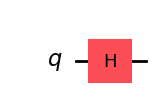

<IPython.core.display.Latex object>

In [22]:
circuit = QuantumCircuit(1) # 1 qubit
circuit.h(0) # apply H to qubit 0
display(circuit.draw('mpl'))

psi = Statevector(circuit) #extract the state
display(psi.draw('latex')) # print


## Simulating the Hadamard circuit

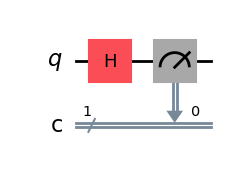

Counts: {'0': 510, '1': 490}


In [23]:
circuit = QuantumCircuit(1, 1) 
circuit.h(0) # apply H to qubit 0
# measure and place result in classical bit
circuit.measure(0, 0) 
display(circuit.draw('mpl'))
backend = Aer.get_backend('qasm_simulator')
new_circuit = transpile(circuit, backend)
job = backend.run(new_circuit,shots = 1000)
counts = job.result().get_counts(circuit)
print('Counts:',counts)

## Function to simulate a circuit on classical computer

In [24]:
def simulateCircuit(circuit,nShots=1000):
	backend = Aer.get_backend('qasm_simulator')
	new_circuit = transpile(circuit, backend)
	job = backend.run(new_circuit,shots = nShots)
	counts = job.result().get_counts(circuit)
	return counts

## Function to run circuit on a real Quantum machine


In [25]:
def runCircuitOnIBMQuantum(circuit,nShots=1024):
	service = QiskitRuntimeService()
	backend = service.least_busy(operational=True, simulator=False)
	print(f"Using backend: {backend}")
	circuit.measure_all()
	pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
	isa_circuit = pm.run(circuit) # optimize the circuit for hardware
	sampler = Sampler(mode=backend) 
	job = sampler.run([isa_circuit],shots = nShots)
	pub_result = job.result()[0]
	return pub_result.data.meas.get_counts()

## RX Circuit

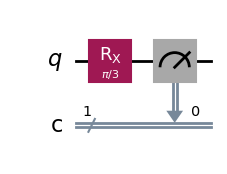

Counts: {'0': 774, '1': 250}


In [26]:
circuit = QuantumCircuit(1, 1)  
circuit.rx(np.pi/3,0) # apply Rx to qubit 0
circuit.measure(0, 0) 
display(circuit.draw('mpl')) 
counts = simulateCircuit(circuit,nShots=1024)
print('Counts:',counts)

## Operators X and H in sequence

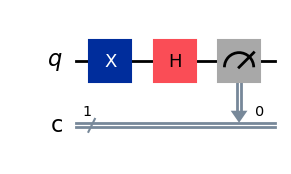

Counts: {'1': 504, '0': 496}


In [27]:
circuit = QuantumCircuit(1, 1)  
circuit.x(0) 
circuit.h(0) 
circuit.measure(0, 0) 
display(circuit.draw('mpl'))
counts = simulateCircuit(circuit,1000)
print('Counts:',counts)

## State preparation

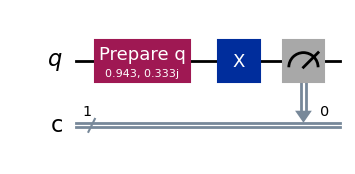

Counts: {'1': 884, '0': 116}


In [28]:
circuit = QuantumCircuit(1, 1)  
q = Statevector([np.sqrt(8)/3, (1j)/3]) 
circuit.prepare_state(q,0,'Prepare q')
circuit.x(0) 
circuit.measure(0, 0) 
display(circuit.draw('mpl'))
counts = simulateCircuit(circuit,1000)
print('Counts:',counts)


## Multi-qubit circuit

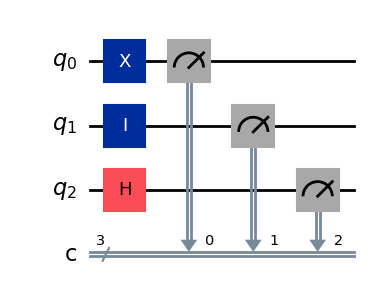

Counts: {'001': 508, '101': 492}


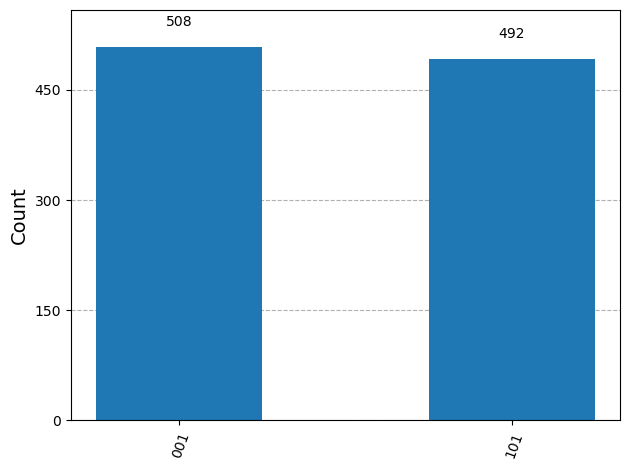

In [29]:
circuit = QuantumCircuit(3, 3)  
circuit.x(0)
circuit.id(1)
circuit.h(2)
circuit.measure([0,1,2], [0,1,2]) 
display(circuit.draw('mpl'))
counts = simulateCircuit(circuit,1000)
print('Counts:',counts)
plot_histogram(counts)

## Multi-qubit, theoretical state

In [30]:
circuit = QuantumCircuit(3, 3)  
circuit.x(0)
circuit.id(1)
circuit.h(2)
psi = Statevector(circuit)
display(psi.draw('latex'))

<IPython.core.display.Latex object>

## Unitary operator

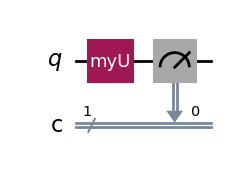

Counts: {'0': 498, '1': 502}


In [31]:
circuit = QuantumCircuit(1, 1) 
UMatrix = 1/np.sqrt(2)*np.array([[1,1],[1j,-1j]]) 
circuit.unitary(UMatrix,0,'myU')
circuit.measure(0,0) 
# To see the theoretical state, comment the previous line and uncomment next 2 lines
# psi = Statevector(circuit)
# display(psi.draw('latex'))
display(circuit.draw('mpl'))
counts = simulateCircuit(circuit,1000)
print('Counts:',counts)

## Universal operator

In [32]:
def UniversalOperator(theta,phi,lambdaAngle):
	U = np.array([[np.cos(theta/2),-np.exp(1j*lambdaAngle)*np.sin(theta/2)],
			      [np.exp(1j*phi)*np.sin(theta/2), np.exp(1j*(phi+lambdaAngle))*np.cos(theta/2)]])
	return U

U = UniversalOperator(np.pi/2,np.pi,np.pi)
print(U)
U = UniversalOperator(np.pi,0,0)
print(U)

[[ 0.70710678+0.00000000e+00j  0.70710678-8.65956056e-17j]
 [-0.70710678+8.65956056e-17j  0.70710678-1.73191211e-16j]]
[[ 6.123234e-17+0.j -1.000000e+00-0.j]
 [ 1.000000e+00+0.j  6.123234e-17+0.j]]


## CNOT Operator

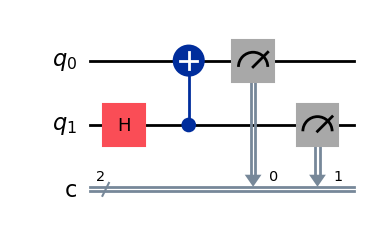

Counts: {'00': 485, '11': 515}


In [33]:
circuit = QuantumCircuit(2, 2)  
circuit.h(1) 
circuit.cx(1,0)
circuit.measure([0,1], [0,1]) 
display(circuit.draw('mpl'))
counts = simulateCircuit(circuit,1000)
print('Counts:',counts)

## Unitary operator of a circuit

In [34]:
circuit = QuantumCircuit(2, 2)  
circuit.cx(1,0)
U = Operator(circuit)
print("U: \n", U.data)

U: 
 [[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]]


## Controlled Hadamard

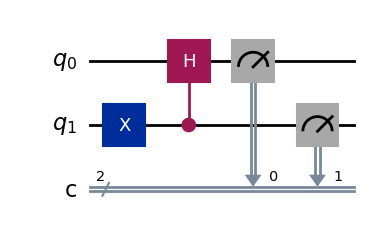

Counts: {'10': 524, '11': 476}


In [35]:
circuit = QuantumCircuit(2, 2)  
circuit.x(1) # try id(1), h(1)
circuit.ch(1,0)
circuit.measure([0,1], [0,1]) 
display(circuit.draw('mpl'))
counts = simulateCircuit(circuit,1000)
print('Counts:',counts)

### CNOT and Controlled Hadamard

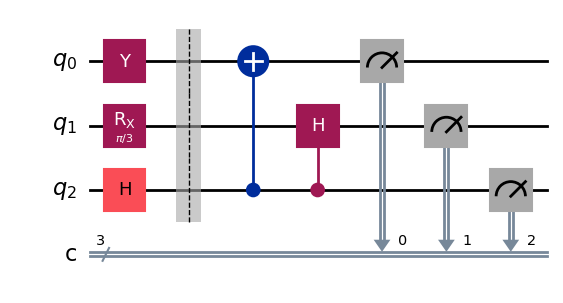

Counts: {'001': 3740, '100': 2510, '011': 1284, '110': 2466}


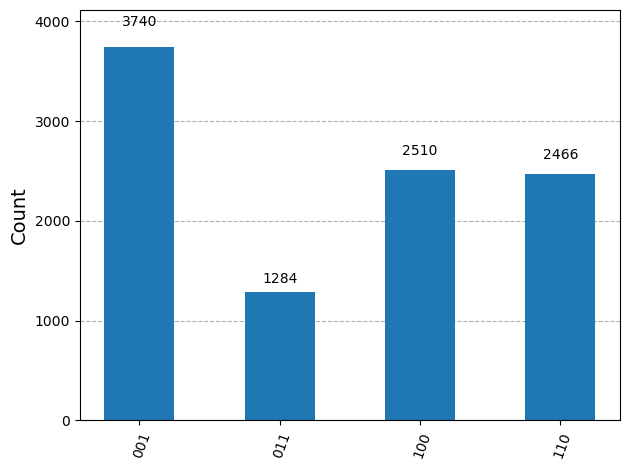

In [36]:
circuit = QuantumCircuit(3, 3) 
circuit.y(0) 
circuit.rx(np.pi/3,1) 
circuit.h(2) 
circuit.barrier()
circuit.cx(2,0)
circuit.ch(2,1)
circuit.measure([0,1,2], [0,1,2]) 
display(circuit.draw('mpl'))
counts = simulateCircuit(circuit,10000)
print('Counts:',counts)
plot_histogram(counts)

### Controlled Phase

<IPython.core.display.Latex object>

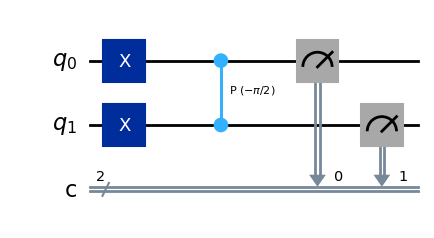

Counts: {'11': 1000}


In [37]:
circuit = QuantumCircuit(2, 2)  
circuit.x(0) 
circuit.x(1) 
circuit.cp(-np.pi/2,0,1)
psi = Statevector(circuit)
display(psi.draw('latex'))

circuit.measure([0,1], [0,1]) 
display(circuit.draw('mpl') )
counts = simulateCircuit(circuit,1000)
print('Counts:',counts)

### Controlled Phase with Hadamard

<IPython.core.display.Latex object>

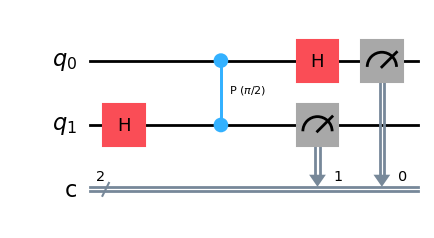

Counts: {'00': 250, '11': 240, '10': 263, '01': 247}


In [38]:
circuit = QuantumCircuit(2, 2)  
circuit.h(1) 
circuit.cp(np.pi/2,0,1)
circuit.h(0) 
psi = Statevector(circuit)
display(psi.draw('latex'))

circuit.measure([0,1], [0,1]) 
display(circuit.draw('mpl')) 
counts = simulateCircuit(circuit,1000)
print('Counts:',counts)


### Complex Circuit

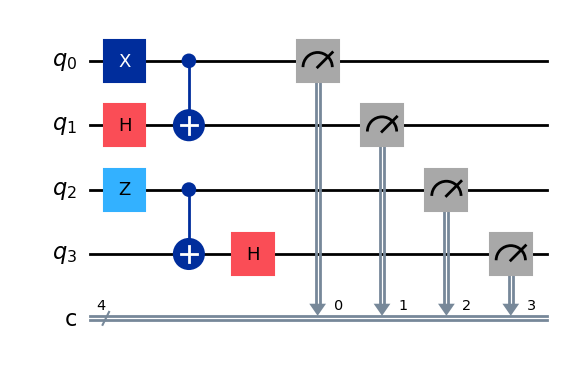

In [39]:
circuit = QuantumCircuit(4, 4)  
circuit.x(0) 
circuit.h(1) 
circuit.z(2)
circuit.cx(0, 1)
circuit.cx(2, 3)
circuit.h(3)
circuit.cx
circuit.measure([0,1,2,3], [0,1,2,3]) 
display(circuit.draw('mpl') )

### Simple Swap

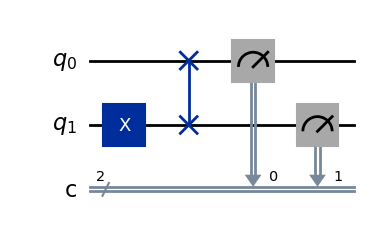

Counts: {'01': 1000}


In [40]:
circuit = QuantumCircuit(2, 2)  
circuit.x(1) 
circuit.swap(1,0)
circuit.measure([0,1], [0,1]) 
display(circuit.draw('mpl'))
counts = simulateCircuit(circuit,1000)
print('Counts:',counts)


### Controlled Unitary

<IPython.core.display.Latex object>

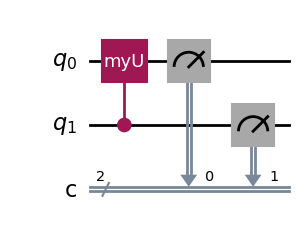

In [41]:
circuit = QuantumCircuit(2, 2) 
UMatrix = 1/np.sqrt(2)*np.array([[1,1],[1j,-1j]]) 
U = UnitaryGate(UMatrix,'myU')
UControl = U.control(1)
circuit.append(UControl,[1,0])
psi = Statevector(circuit) #extract the state
display(psi.draw('latex')) # print
circuit.measure([0,1],[0,1]) 
display(circuit.draw('mpl'))

### Toffoli Gate

### State-controlled U Gate

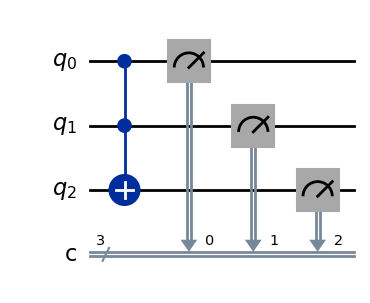

In [42]:
circuit = QuantumCircuit(3, 3) 
circuit.ccx(0,1,2)
circuit.measure([0,1,2],[0,1,2])
display(circuit.draw('mpl')) 

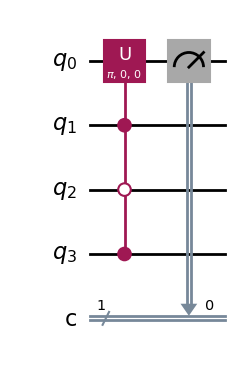

In [43]:
circuit = QuantumCircuit(4, 1) 
cu_gate = UGate(np.pi, 0, 0).control(3, ctrl_state = '101')
# Not sure why the following does not work
# circuit.cry(theta = np.pi/3,target_qubit= 0,
#      control_qubit = [1,2,3], ctrl_state = '101')
circuit.append(cu_gate,[1,2,3,0])
circuit.measure([0],[0]) 
display(circuit.draw('mpl') )


# Chapter 6: Quantum Tests and Fundamental Algorithms

## Hadamard Tests

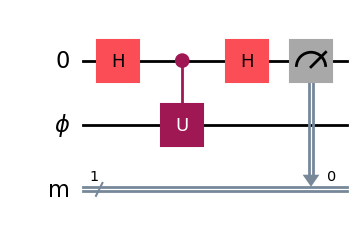

Counts: {'0': 850, '1': 150}


In [44]:
zeroQubit = QuantumRegister(1, '0')
phiQubit = QuantumRegister(1, '\u03D5')
cl = ClassicalRegister(1,'m')
circuit = QuantumCircuit(zeroQubit,phiQubit, cl) 
circuit.h(0)
#circuit.sdg(0)
UMatrix = 1/np.sqrt(2)*np.array([[1,1],[1j,-1j]]) 
U = UnitaryGate(UMatrix,'U')
UControl = U.control(1)
circuit.append(UControl,[0,1])
circuit.h(0)
circuit.measure(0,0) 
display(circuit.draw('mpl'))
counts = simulateCircuit(circuit,1000)
print('Counts:',counts)

### Inner Product

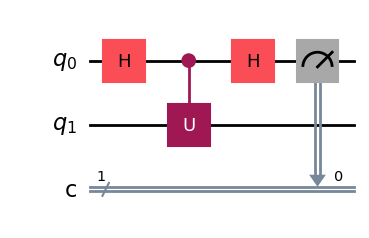

Counts: {'0': 98, '1': 2}


In [45]:
circuit = QuantumCircuit(2, 1) 
circuit.h(0)
a = np.sqrt(3)
b = 1/np.sqrt(2)
UMatrix = b*np.array([[(a+1)/2,(a-1)/2],[(a-1)/2,(-a-1)/2]])
U = UnitaryGate(UMatrix,'U')
UControl = U.control(1)
circuit.append(UControl,[0,1])
circuit.h(0)
circuit.measure(0,0) 
display(circuit.draw('mpl'))
counts = simulateCircuit(circuit,100)
print('Counts:',counts)

### Inner Product-Real

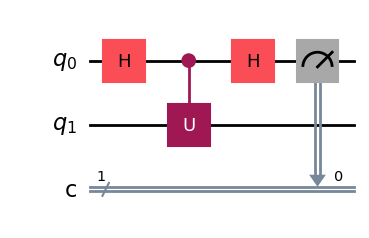

dotprod: 0.8652


In [46]:
def ryMatrix(alpha):
	return np.array([[np.cos(alpha/2), -np.sin(alpha/2)], [np.sin(alpha/2), np.cos(alpha/2)]])
	
U_phi = ryMatrix(2*np.pi/3)
U_psi = ryMatrix(np.pi/3)
UMatrix = np.matmul(U_phi.conj().T,U_psi)

circuit = QuantumCircuit(2, 1) 
circuit.h(0)
U = UnitaryGate(UMatrix,'U')
UControl = U.control(1)
circuit.append(UControl,[0,1])
circuit.h(0)
circuit.measure(0,0) 
display(circuit.draw('mpl'))
nShots = 10000
counts = simulateCircuit(circuit,nShots)

dotprod = 2*counts['0']/nShots - 1
print('dotprod:',dotprod)

### Inner product: Imaginary

In [47]:
def ryMatrix(alpha):
	return np.array([[np.cos(alpha/2), -np.sin(alpha/2)], [np.sin(alpha/2), np.cos(alpha/2)]])

def rzMatrix(omega):
	return np.array([[np.exp(-1j*omega/2), 0], [0, np.exp(1j*omega/2)]])
	
	
U_phi = ryMatrix(2*np.pi/3)
U_psi = rzMatrix(-np.pi)
UMatrix = np.matmul(U_phi.conj().T,U_psi)
phi = np.matmul(U_phi,np.array([1,0]))
psi = np.matmul(U_psi,np.array([1,0]))
print('Exact:', np.dot(phi,psi))

circuit = QuantumCircuit(2, 1) 
circuit.h(0)
circuit.sdg(0)
U = UnitaryGate(UMatrix,'U')
UControl = U.control(1)
circuit.append(UControl,[0,1])
circuit.h(0)
circuit.measure(0,0) 
circuit.draw('mpl')
nShots = 10000
counts = simulateCircuit(circuit,nShots)

dotprod = (counts['0'] - counts['1'])/nShots
print('dotprod:',dotprod)

Exact: (3.0616169978683836e-17+0.5000000000000001j)
dotprod: 0.4992


### Inner product: Negative Real

Exact: -0.9659258262890684


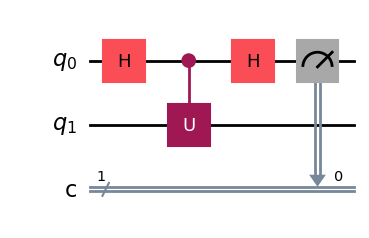

dotprod: -0.9644


In [48]:
def ryMatrix(alpha):
	return np.array([[np.cos(alpha/2), -np.sin(alpha/2)], [np.sin(alpha/2), np.cos(alpha/2)]])
	
U_phi = ryMatrix(2*np.pi/3)
U_psi = ryMatrix(5*np.pi/2)

phi = np.matmul(U_phi,np.array([1,0]))
psi = np.matmul(U_psi,np.array([1,0]))
print('Exact:', np.dot(phi,psi))
UMatrix = np.matmul(U_phi.conj().T,U_psi)

circuit = QuantumCircuit(2, 1) 
circuit.h(0)
U = UnitaryGate(UMatrix,'U')
UControl = U.control(1)
circuit.append(UControl,[0,1])
circuit.h(0)
circuit.measure(0,0) 
display(circuit.draw('mpl'))
nShots = 10000
counts = simulateCircuit(circuit,nShots)

dotprod = (counts['0'] - counts['1'])/nShots
print('dotprod:',dotprod)

### Swap test concept

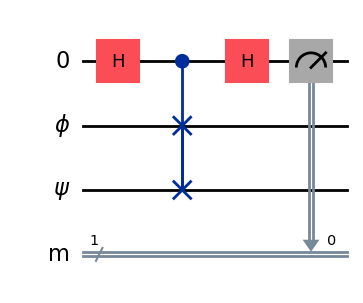

In [49]:
zeroQubit = QuantumRegister(1, '0')
psiQubit = QuantumRegister(1, '\u03C8')
phiQubit = QuantumRegister(1, '\u03D5')
cl = ClassicalRegister(1,'m')
circuit = QuantumCircuit(zeroQubit,phiQubit,psiQubit,cl) 
circuit.h(0)

circuit.cswap(zeroQubit, psiQubit, phiQubit)
circuit.h(0)
circuit.measure(0,0) 
display(circuit.draw('mpl')) 


### Swap test example

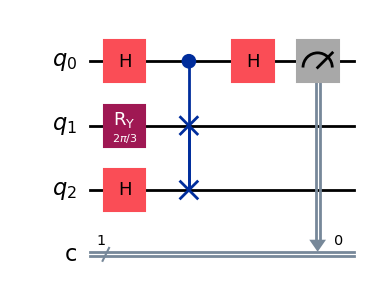

Counts: {'0': 9677, '1': 323}
dotprodSqr: 0.9354


In [50]:
circuit = QuantumCircuit(3,1) 
circuit.h(0)
circuit.ry(2*np.pi/3, 1)
circuit.h(2)
circuit.cswap(0, 1, 2)
circuit.h(0)
circuit.measure(0,0) 
display(circuit.draw('mpl')) 
counts = simulateCircuit(circuit,10000)
print('Counts:',counts)

P0 = (counts['0'])/10000
print('dotprodSqr:',2*P0-1)

## Bernstein Vazarani Algorithm

#### Secret Circuit

In [51]:
def createSecretCircuit():
    s = '11010' # the hidden string
    n = len(s)
    secretCircuit = QuantumCircuit(n+1)
    for ii, yesno in enumerate(reversed(s)):
        if yesno == '1': 
            secretCircuit.cx(ii+1, 0)
    display(secretCircuit.draw('mpl'))
    U = Operator(secretCircuit)
    return U, n

### Berstein Vazarani Circuit 

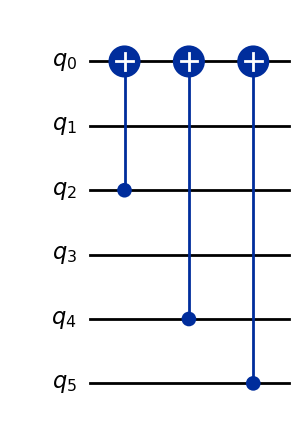

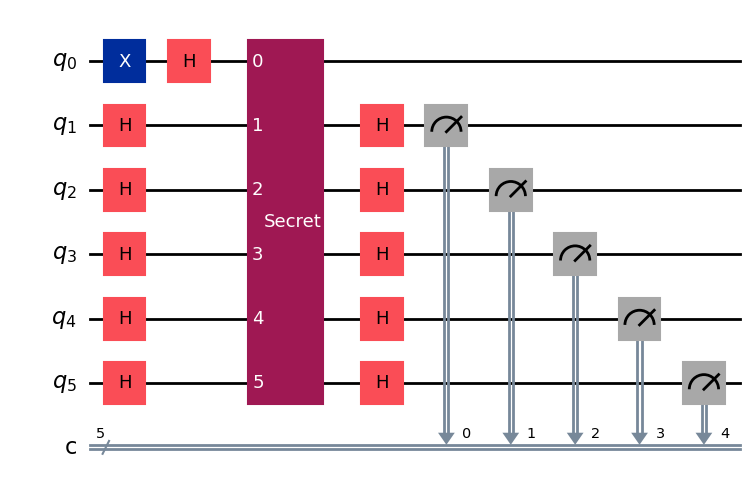

{'11010': 1}
The total depth is  5
The total width is  11


In [52]:
U, n = createSecretCircuit()
circuit = QuantumCircuit(n+1,n)
circuit.x(0) 
circuit.h(0) # This brings qubit 0 to |-> state
circuit.h(range(1,n+1)) 
circuit.unitary(U,range(n+1),'Secret')
circuit.h(range(1,n+1))
circuit.measure(range(1,n+1), range(0,n)) 
display(circuit.draw('mpl')) 
counts = simulateCircuit(circuit,1)
print(counts)
print("The total depth is ", circuit.depth())
print("The total width is ", circuit.width())

## Grover algorithm

### Oracle circuit

In [53]:
from qiskit.circuit.library import PhaseOracle

def secret_circuit():
    expression = '~q_0 & q_1 & (~q_2) & q_3 & q_4'  # secret state 11010
    circuit = PhaseOracle(expression) # convenient way to create oracle
    return circuit

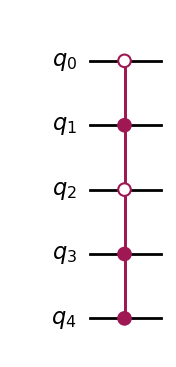

In [105]:
from qiskit.circuit.library import grover_operator

oracle = secret_circuit()
grover_op = grover_operator(oracle)
nQubits = grover_op.num_qubits
N = 2**nQubits
K = math.floor(math.pi / (4 * math.asin(math.sqrt(1 / N))))
print("Optimal number of Grover iterations:", K)
qc = QuantumCircuit(grover_op.num_qubits)

qc.h(range(grover_op.num_qubits)) # Create  superposition of all basis states
# Apply Grover operator the optimal number of times
qc.compose(grover_op.power(K), inplace=True)
qc.measure_all()

counts = simulateCircuit(qc,1024)
print(counts)

Optimal number of Grover iterations: 4
{'11010': 1022, '00100': 1, '10000': 1}


# Chapter 6: Quantum Fourier Transform

In this chapter, we will study Quantum Fourier Transform (QFT), an extremely useful quantum algorithm, and its
quantum circuit implementation. QFT is the quantum equivalent of Discrete Fourier Transform (DFT), and plays
a vital role in many applications, including the solution of quantum phase estimation, Shor’s algorithm, machine
learning, etc. We will briefly review digital signals and their processing as a motivation to QFT.

## Signal Processing

### Import packages

In [56]:
from qiskit.circuit.library import QFTGate

np.set_printoptions(precision =3,suppress=True)

### Trigonometric functions

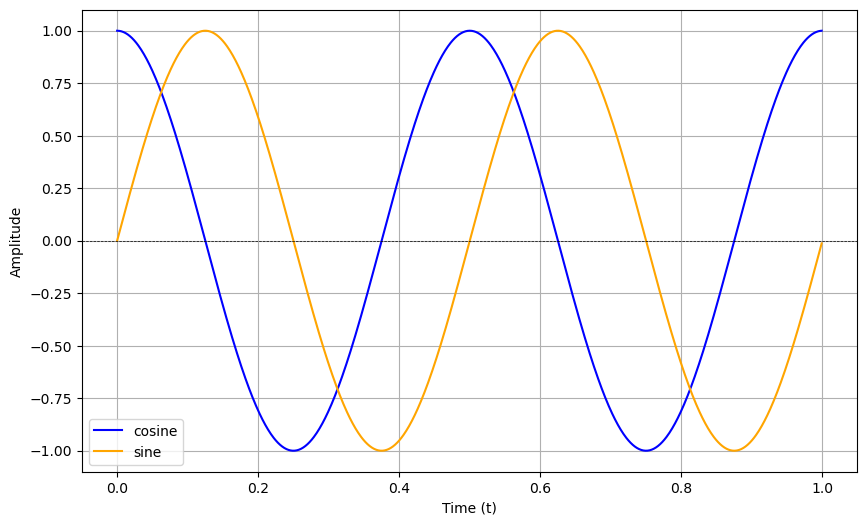

In [57]:
T = 1/2 # Period
omega = 2 * np.pi / T  # Angular frequency
nContinuousSamples = 1000 # for plotting
tPlot = np.linspace(0,1,nContinuousSamples,endpoint = False)
# Generate cosine and sine values
cosine_wave = np.cos(omega * tPlot)
sine_wave = np.sin(omega * tPlot)

# Plot the waves
plt.figure(figsize=(10, 6))
plt.plot(tPlot, cosine_wave, label='cosine', color='blue')
plt.plot(tPlot, sine_wave, label='sine', color='orange')
plt.xlabel('Time (t)')
plt.ylabel('Amplitude')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.legend()
plt.grid(True)
plt.show()

### Repeating band-limited signals

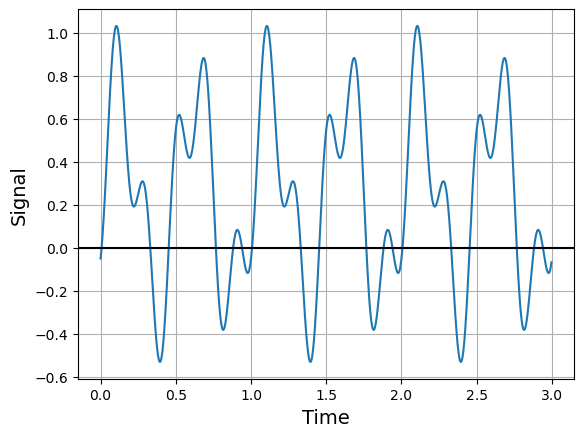

In [58]:
def trignometricSignal(t,c = [],s = []):
	signal = sum(ck * np.cos(k * 2 * np.pi * t) for k, ck in enumerate(c)) + \
		sum(sk * np.sin(k * 2 * np.pi * t) for k, sk in enumerate(s))
	return signal

example = 3
if (example == 1):
	c = [0]
	s = [0, 0.5]
elif (example == 2):
	c = [0]
	s = [0, -0.3]
elif (example == 3):
	c = [0.25, 0 , 0, 0,0,-0.3]
	s = [0, 0, 0.5]
else:
	c = [-0.6*2/np.pi]
	s = [0.6]


T = 3
nContinuousSamples = 1000 # for plotting
tPlot = np.linspace(0,T,nContinuousSamples,endpoint = False)
yPlot = trignometricSignal(tPlot,c,s)
plt.plot(tPlot,yPlot)
plt.axhline(0, color='black')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Signal', fontsize=14)
plt.grid(visible=True)

### Repeating signal that is not band-limited

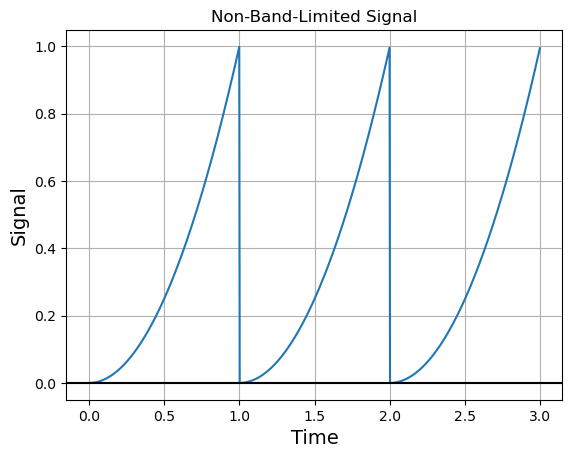

In [59]:
def non_band_limited_signal(t):
    signal = ((t-1) % 1)**2 
    return signal

T = 3  # Time period
nContinuousSamples = 1000  # For plotting
tPlot = np.linspace(0, T, nContinuousSamples, endpoint=False)
yPlot = non_band_limited_signal(tPlot)

plt.plot(tPlot, yPlot)
plt.axhline(0, color='black')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Signal', fontsize=14)
plt.title('Non-Band-Limited Signal')
plt.grid(visible=True)
plt.show()

## Continuous Signal

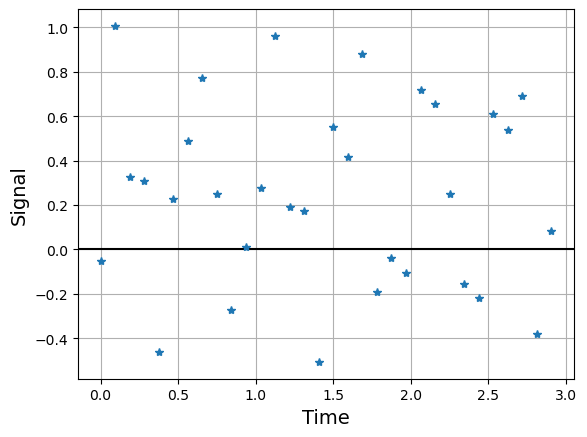

In [60]:


M = 32 # We set the number of discrete samples here
t = np.linspace(0,T,M,endpoint = False) # need to eliminate the last point
yDigital = trignometricSignal(t,c,s)

plt.figure()
plt.axhline(0, color='black')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Signal', fontsize=14)
plt.grid(visible=True)
plt.plot(t,yDigital,'*')

## DFT Signal Processing

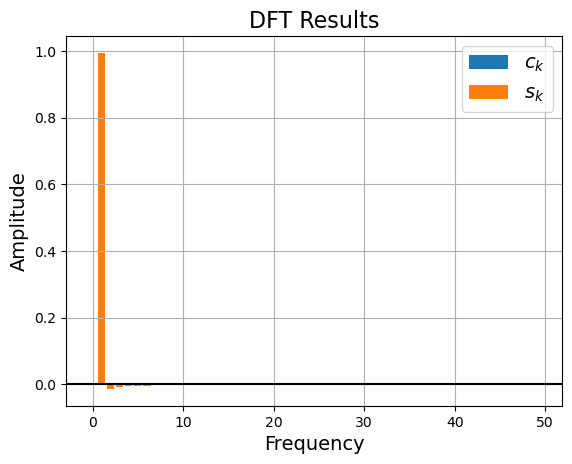

In [61]:
def createDFTMatrix(M):
    DFTMatrix = np.zeros((M,M), dtype=complex)
    omega = np.exp(1j*(2*np.pi/M))
    for i in range(M):
        for j in range(M):
            DFTMatrix[i][j] = omega**(-i*j)
    return DFTMatrix 

M = len(y)
DFTMatrix = createDFTMatrix(M)
phi = np.matmul(DFTMatrix,y)
def processDFTResult(phi):
	M = len(phi)
	phi = phi/M
	c = np.zeros(int(M/2))
	s = np.zeros(int(M/2))
	c[0] =  phi[0].real # constant
	c[1:] = (phi[1:int(M/2)]+phi[M-1:int(M/2):-1]).real; # cosine terms
	s =  (phi[M-1:int(M/2):-1] - phi[1:int(M/2)]).imag; # sine terms
	s = np.insert(s, 0,0)
	return [c,s]

[c,s] = processDFTResult(phi)

def plotDFTResults(c,s,M):
	plt.figure()
	plt.bar(list(range(0,int(M/2))),c, label =r"$c_k$")
	plt.bar(list(range(0,int(M/2))),s, label =r"$s_k$")
	plt.legend( fontsize=14)
	plt.axhline(0, color='black')
	plt.xlabel('Frequency', fontsize=14)
	plt.ylabel('Amplitude', fontsize=14)

	plt.title('DFT Results', fontsize=16)
	plt.grid(visible=True)
	plt.show()
      
plotDFTResults(c,s,M)


## QFT with 2 qubits

[[ 0.5+0.j   0.5+0.j   0.5+0.j   0.5+0.j ]
 [ 0.5+0.j   0. +0.5j -0.5+0.j  -0. -0.5j]
 [ 0.5+0.j  -0.5+0.j   0.5+0.j  -0.5+0.j ]
 [ 0.5+0.j  -0. -0.5j -0.5+0.j   0. +0.5j]]
Counts: {'10': 257, '11': 268, '01': 252, '00': 223}


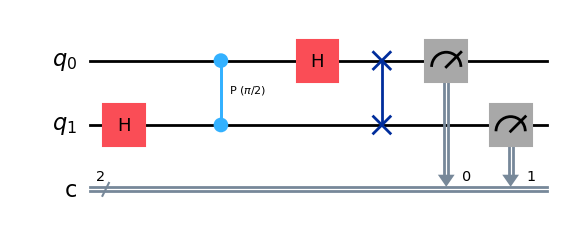

In [62]:
circuit = QuantumCircuit(2, 2)  
circuit.h(1)
circuit.cp(np.pi/2,0,1) 
circuit.h(0) 
circuit.swap(0,1)
print(np.array(Operator(circuit).data))
circuit.measure([0,1], [0,1]) 
counts = simulateCircuit(circuit,1000)
print('Counts:',counts)
circuit.draw('mpl') 

## Qiskit's QFTGate

U from circuit:
 [[ 0.5+0.j   0.5+0.j   0.5+0.j   0.5+0.j ]
 [ 0.5+0.j   0. +0.5j -0.5+0.j  -0. -0.5j]
 [ 0.5+0.j  -0.5+0.j   0.5-0.j  -0.5+0.j ]
 [ 0.5+0.j  -0. -0.5j -0.5+0.j   0. +0.5j]]


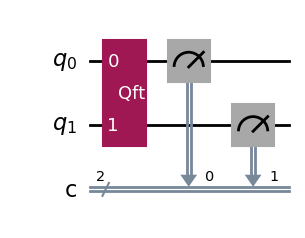

In [63]:
m = 2 # number of qubits
circuit = QuantumCircuit(m, m) 
qft = QFTGate(num_qubits=m)
UFromCircuit = Operator(qft)
print("U from circuit:\n", UFromCircuit.data)
circuit.append(qft, qargs=list(range(m)))
circuit.measure(list(range(m)),list(range(m))) 
circuit.draw('mpl')


## QFTGate with m = 3

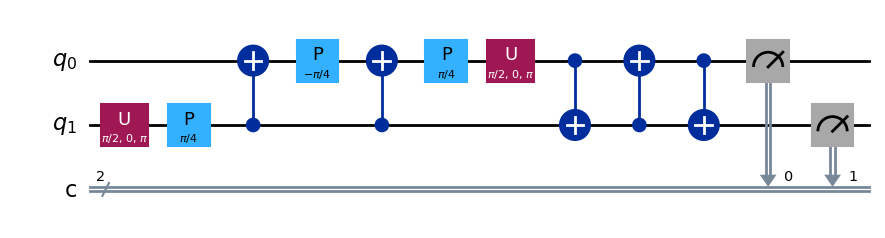

In [64]:
m = 2 # number of qubits
circuit = QuantumCircuit(m, m) 
qft = QFTGate(num_qubits=m)
circuit.append(qft, qargs=list(range(m)))
circuit.measure(list(range(m)),list(range(m))) 
circuit.decompose(reps=2).draw('mpl')


## QFT Signal Processing using Qiskit's QFTGate

Number of qubits: 5


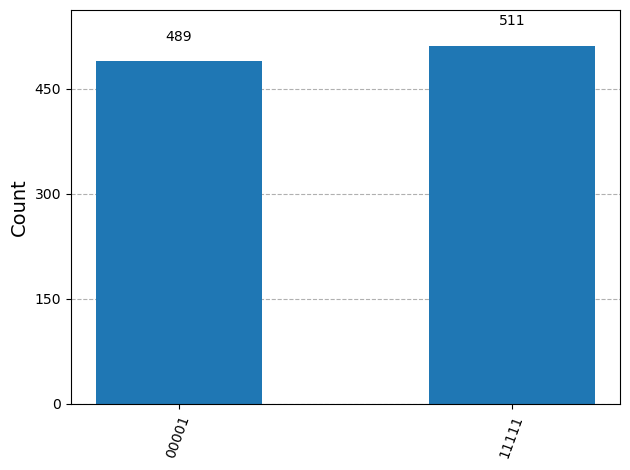

In [65]:
def QFTSignalProcessing(y,nShots):
	M = len(y) # length of signal
	m = int(np.log2(M)) # number of qubits
	print('Number of qubits:',m)
	circuit = QuantumCircuit(m, m)  
	q = Statevector(y/np.linalg.norm(y)) 
	circuit.prepare_state(q,list(range(m)),'Prepare q')
	qftCircuit = QFTGate(num_qubits=m)
	circuit.append(qftCircuit, qargs=list(range(m)))
	circuit.measure(list(range(m)),list(range(m))) 
	counts = simulateCircuit(circuit,nShots=nShots)
	
	return counts
M = 32
t = np.linspace(0,1,M,endpoint = False) # need to eliminate the last point
y = trignometricSignal(t,c,s)
nShots = 1000
counts = QFTSignalProcessing(y,nShots)
plot_histogram(counts)

### Processing QFT results

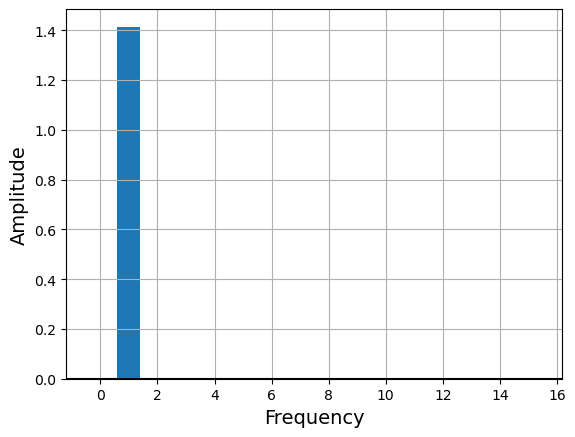

In [66]:
def processQFTResult(counts,nShots):
	phi = np.zeros(M)
	for i in counts:
		freq = int(i, 2)
		phi[freq] = np.sqrt(counts[i]/nShots)
	ampl = (phi[1:int(M/2)])+(phi[M-1:int(M/2):-1]);
	ampl = np.insert(ampl, 0,phi[0].real)
	return ampl
	
ampl = processQFTResult(counts,nShots)

plt.figure()
plt.bar(list(range(0,int(M/2))),ampl)
plt.axhline(0, color='black')
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
plt.grid(visible=True)


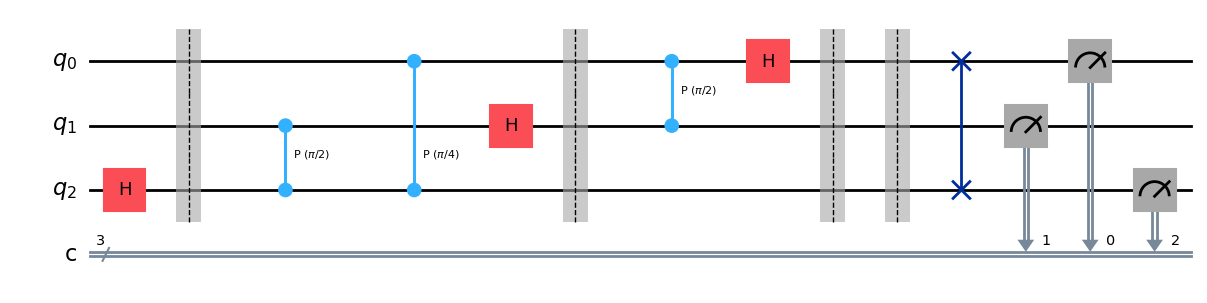

In [67]:
def myQFT(m): # m is the # of qubits
    q = QuantumRegister(m, 'q')
    c = ClassicalRegister(m,'c')
    circuit = QuantumCircuit(q,c)
    for k in range(m):
        kk = m - k
        circuit.h(q[kk-1])
        circuit.barrier()
        for i in reversed(range(kk-1)):
            circuit.cp(2*np.pi/2**(kk-i),q[i], q[kk-1])
      
    circuit.barrier()  
    for i in range(m//2):
        circuit.swap(q[i], q[m-i-1])
    return circuit

m = 3
circuit = myQFT(m)
circuit.measure(list(range(m)),list(range(m))) 
circuit.draw('mpl') 

### QFT Matrix Verification

In [68]:
def createQFTMatrix(M):
    QFTMatrix = np.zeros((M,M), dtype=complex)
    omega = np.exp(1j*(2*np.pi/M))
    for i in range(M):
        for j in range(M):
            QFTMatrix[i][j] = omega**(i*j)
    return QFTMatrix/np.sqrt(M)


In [69]:
m = 2
circuit = myQFT(m)
UFromCircuit = Operator(circuit)
UExact = createQFTMatrix(2**m)
print("Error: ", round(np.linalg.norm(UFromCircuit-UExact),10))

Error:  0.0


## 1D Poisson Equation

### Forcing function f(x) and solution u(x)

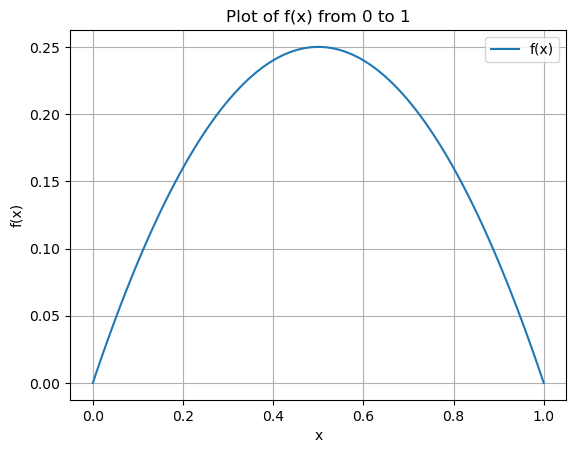

In [70]:
def Poisson1DForcingFunction(x, L = 1):
    example = 1
    if (example == 1):  
       return x*(L - x)
    elif (example == 2):
        alpha_0 = 0.3
        alpha_1 = 0.1
        alpha_2 = -0.1772
        return np.exp(-((x - alpha_0) ** 2) / (alpha_1 ** 2)) + alpha_2

def Poisson1DSolution(x, L = 1):
     example = 1
     if (example == 1):
         return -x**3/6 + x**4/12 + x/12
     elif (example == 2):
        alpha_0 = 0.3
        alpha_1 = 0.1
        alpha_2 = -0.1772
        alpha_3 = 0.053
        alpha_4 = -0.0266
        term1 = (alpha_1 * np.sqrt(np.pi) / 2) * (x - alpha_0) * scipy.special.erf((x - alpha_0) / alpha_1)
        term2 = (alpha_1 / (np.sqrt(np.pi))) * np.exp(-((x - alpha_0)**2) / alpha_1**2)
        term3 = (alpha_2 * x**2) / 2
        term4 = alpha_3 * x + alpha_4
        return term1 + term2 + term3 + term4
     
# Generate x values from 0 to 1
x = np.linspace(0, 1, 100)

# Calculate f(x) for each x
f = Poisson1DForcingFunction(x)

# Create the plot
plt.plot(x, f, label="f(x)")
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Plot of f(x) from 0 to 1')
plt.grid(True)
plt.legend()
plt.show()

### Digital signal of f

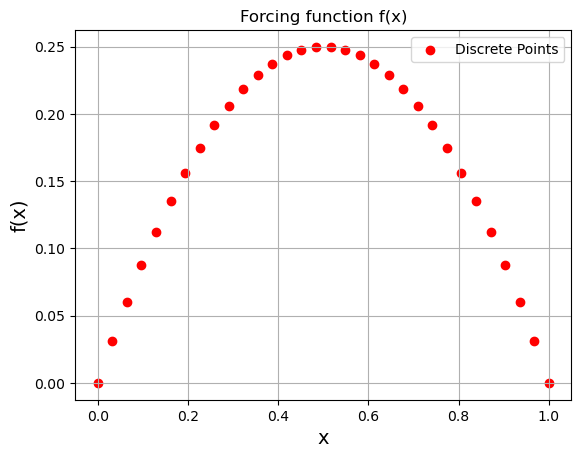

In [71]:
M = 32  # discretization points
L = 1  # domain length
nShots = 1000
x = np.linspace(0, L, M)
fj = Poisson1DForcingFunction(x)
plt.figure()
plt.scatter(x, fj, color='red', label="Discrete Points")
plt.xlabel('x', fontsize=14)
plt.ylabel('f(x)', fontsize=14)
plt.title('Forcing function f(x)')
plt.grid(visible=True)
plt.legend()

### DFT of f(x)

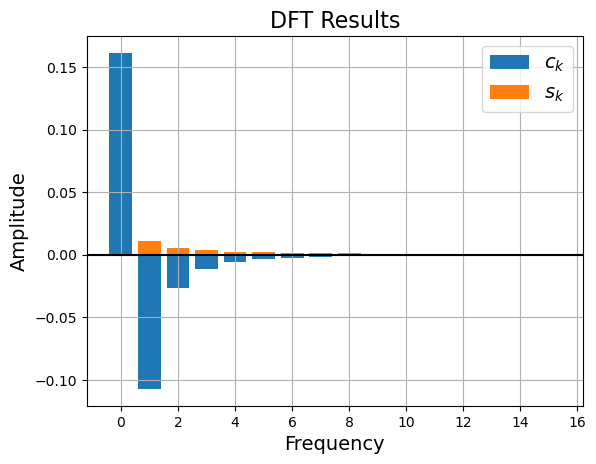

In [72]:
DFTMatrix = createDFTMatrix(M)
phi = np.matmul(DFTMatrix,fj)

[c,s] = processDFTResult(phi)

plotDFTResults(c,s,M)

### QFT of f(x)

Number of qubits: 5


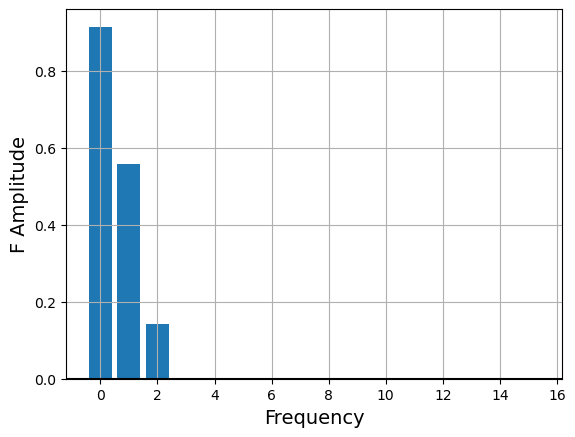

In [73]:
fj_norm = np.linalg.norm(fj) # store for scaling

counts = QFTSignalProcessing(fj, nShots)
Fk = processQFTResult(counts, nShots)


plt.figure()
plt.bar(list(range(0,int(M/2))),Fk)
plt.axhline(0, color='black')
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('F Amplitude', fontsize=14)
plt.grid(visible=True)

### Regenerate f(x) from QFT results

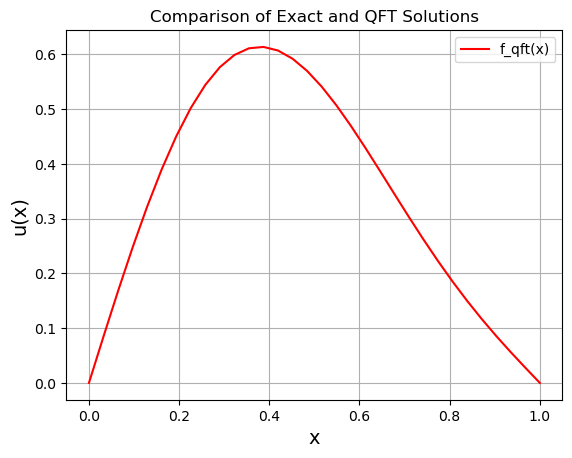

In [74]:
f_qft = np.sum([Fk[k] * np.sin(np.pi * k * x/L) for k in range(1, len(Fk))], axis=0)
plt.figure()
plt.plot(x, f_qft, label='f_qft(x)', color='red')
plt.xlabel('x', fontsize=14)
plt.ylabel('u(x)', fontsize=14)
plt.title('Comparison of Exact and QFT Solutions')
plt.legend()
plt.grid(visible=True)

### Solution u(x)

1.0165294951093038


Text(0, 0.5, 'U Amplitude')

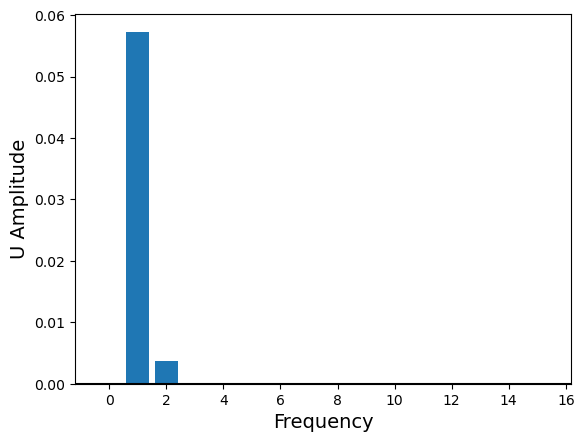

In [75]:
print(fj_norm)
Uk = np.zeros(len(Fk))
for k in range(1, len(Fk)):
    Uk[k] = fj_norm * Fk[k] / (np.pi * k*L)**2

plt.figure()
plt.bar(list(range(0,int(M/2))),Uk)
plt.axhline(0, color='black')
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('U Amplitude', fontsize=14)



### Hybrid solution

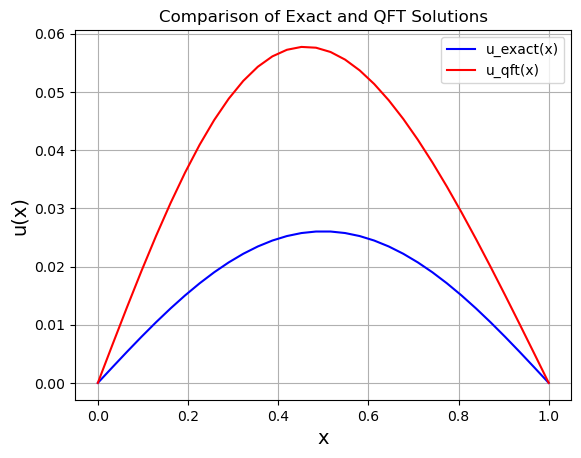

In [76]:
u_qft = np.sum([Uk[k] * np.sin(np.pi * k * x/L) for k in range(1, len(Uk))], axis=0)
u_exact = Poisson1DSolution(x, L)
plt.figure()
plt.plot(x, u_exact, label='u_exact(x)', color='blue')
plt.plot(x, u_qft, label='u_qft(x)', color='red')
plt.xlabel('x', fontsize=14)
plt.ylabel('u(x)', fontsize=14)
plt.title('Comparison of Exact and QFT Solutions')
plt.legend()
plt.grid(visible=True)

## Inverse QFT

<IPython.core.display.Latex object>

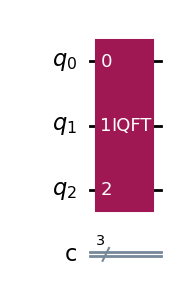

In [77]:
m = 3 # number of qubits
circuit = QuantumCircuit(m, m) 
iqft = QFTGate(num_qubits=m).inverse()
iqft._name = 'IQFT'
circuit.append(iqft, qargs=list(range(m)))

psi = Statevector(circuit)
display(psi.draw('latex'))
circuit.draw('mpl')

# Chapter 7: Quantum Phase Estimation

Quantum phase estimation (QPE), a second fundamental algorithm in quantum computing. QPE is a critical component of various QC algorithms. The main objective of QPE is, given an eigenvector of a (typically unitary) matrix, to estimate the
corresponding eigenvalue. 

## Import packages

In [78]:

from qiskit.circuit.library import QFT, phase_estimation, HamiltonianGate


## Hamiltonian

[[-0.25+0.433j  0.75+0.433j]
 [ 0.75+0.433j -0.25+0.433j]]


<IPython.core.display.Latex object>

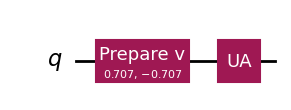

In [79]:
A = np.array([[2,-1],[-1,2]])
f = 0.5
lambdaUpper = 3
t = -2*np.pi*f/lambdaUpper #Note negative
U_A = HamiltonianGate(A, time=t,label = 'UA')
print(np.array(U_A.to_matrix()))
v = np.array([1/np.sqrt(2),-1/np.sqrt(2)])
circuit = QuantumCircuit(1)
circuit.prepare_state(Statevector(v) ,0,'Prepare v')
circuit.append(U_A, qargs=[0])
psi = Statevector(circuit)
display(psi.draw('latex'))
circuit.draw('mpl') 

## Control gate

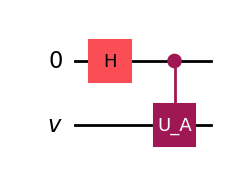

In [80]:
zeroQubit = QuantumRegister(1, '0')
vQubit = QuantumRegister(1, 'v')
circuit = QuantumCircuit(zeroQubit,vQubit) 
circuit.h(0)
UMatrix = 1/np.sqrt(2)*np.array([[1,1],[1j,-1j]]) 
U = UnitaryGate(UMatrix,'U_A')
UControl = U.control(1)
circuit.append(UControl,[0,1])
circuit.draw('mpl') 

## Probability Model

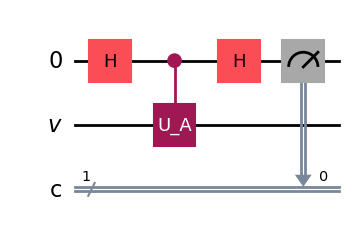

In [81]:
zeroQubit = QuantumRegister(1, '0')
vQubit = QuantumRegister(1, 'v')
cBit = ClassicalRegister(1, 'c')
circuit = QuantumCircuit(zeroQubit,vQubit,cBit) 
circuit.h(0)
UMatrix = 1/np.sqrt(2)*np.array([[1,1],[1j,-1j]]) 
U = UnitaryGate(UMatrix,'U_A')
UControl = U.control(1)
circuit.append(UControl,[0,1])
circuit.h(0)
circuit.measure([0], [0]) 
circuit.draw('mpl') 


## Single digit QPE with multiple qubits v

In [82]:
def myQPESingleBit(A,v,lambdaUpper,nShots=1000):
	n = int(np.log2(v.shape[0]))
	circuit = QuantumCircuit(n+1,1)
	circuit.h(0)
	circuit.prepare_state(Statevector(v),[*range(1, n+1)],'v')
	t = -2*np.pi/lambdaUpper #Note negative
	U_A = HamiltonianGate(A, time=t,label = 'UA')
	UControl = U_A.control(1) # only 1 control qubit
	circuit.append(UControl,[*range(0, n+1)])
	circuit.h(0)
	circuit.measure([0], [0]) 
	counts = simulateCircuit(circuit,nShots)
	print('Counts:',counts)
	probabilities = np.array([])
	thetaEstimates = np.array([])
	for key in counts:
		probabilities = np.append(probabilities,counts[key]/nShots)
		thetaEstimates = np.append(thetaEstimates,int(key, 2)/(2))
	return [thetaEstimates,probabilities]

### Example 1

In [83]:
A = np.array([[1,0],[0,0.75]])
v = np.array([1,0])
lambdaUpper = 2

[thetaEstimates,probabilities] = myQPESingleBit(A,v,lambdaUpper,nShots=1000)
print("Theta estimates:", thetaEstimates)
print("Probabilities:", probabilities)

Counts: {'1': 1000}
Theta estimates: [0.5]
Probabilities: [1.]


### Example 2

In [84]:
A = np.array([[1,0],[0,0.75]])
v = np.array([0,1])
lambdaUpper = 2

[thetaEstimates,probabilities] = myQPESingleBit(A,v,lambdaUpper,nShots=1000)
print("Theta estimates:", thetaEstimates)
print("Probabilities:", probabilities)

Counts: {'1': 873, '0': 127}
Theta estimates: [0.5 0. ]
Probabilities: [0.873 0.127]


## Multiple digit QPE 

In [85]:
def myQPEMultiBit(A,v,lambdaUpper,m,nShots=1000):
	N = v.shape[0]
	n = int(np.log2(N))
	phase_qubits = QuantumRegister(m, '\u03B8')
	input_qubits = QuantumRegister(n, 'v')
	phase_measurements = ClassicalRegister(m, '\u0398')
	circuit = QuantumCircuit(phase_qubits,input_qubits,phase_measurements)
	for i in range(m):
		circuit.h(i)
	circuit.prepare_state(Statevector(v),[*range(m, n+m)],'v')
	t = -2*np.pi/lambdaUpper #Note negative
	U_A = HamiltonianGate(A, time=t,label = 'UA')
	U_A._name = 'UA'
	for i in range(m):
		U_A_pow = U_A.power(2**i) 
		UControl = U_A_pow.control(1) # only 1 control qubit
		circuit.append(UControl,[i,*range(m, n+m)])
	iqft = QFTGate(num_qubits=m).inverse()
	iqft._name = 'IQFT'
	circuit.append(iqft, [*range(0,m)])
	circuit.measure([*range(0,m)], [*range(0,m)]) 
	circuit.draw('mpl') 
	counts = simulateCircuit(circuit,nShots)
	print(counts)
	countsSorted = {k: v for k, v in sorted(counts.items(), 
										 key=lambda item: item[1],
										 reverse=True)}
	probabilities = np.array([])
	thetaEstimates = np.array([])
	for key in countsSorted:
		probabilities = np.append(probabilities,countsSorted[key]/nShots)
		thetaEstimates = np.append(thetaEstimates,int(key, 2)/(2**m))
	return [thetaEstimates,probabilities]

### Multibit Example 1

In [86]:
A = np.array([[1,0],[0,0.75]])
v = np.array([0,1])
lambdaUpper = 2
nThetaBits = 2

[thetaEstimates,probabilities] = myQPEMultiBit(A,v,lambdaUpper,m = nThetaBits, nShots=1000)
thetaTilde = np.sum(thetaEstimates*probabilities)
print("Theta estimates:", thetaEstimates)
print("Probabilities:", probabilities)
print("thetaTilde: ", thetaTilde)

{'00': 72, '01': 451, '10': 403, '11': 74}
Theta estimates: [0.25 0.5  0.75 0.  ]
Probabilities: [0.451 0.403 0.074 0.072]
thetaTilde:  0.36975


### Multibit Example 2

In [87]:
nThetaBits = 3

[thetaEstimates,probabilities] = myQPEMultiBit(A,v,lambdaUpper,m = nThetaBits, nShots=1000)
thetaTilde = np.sum(thetaEstimates*probabilities)
print("Theta estimates:", thetaEstimates)
print("Probabilities:", probabilities)
print("thetaTilde: ", thetaTilde)

{'011': 1000}
Theta estimates: [0.375]
Probabilities: [1.]
thetaTilde:  0.375


### Multibit Example 3

In [88]:
nThetaBits = 5

[thetaEstimates,probabilities] = myQPEMultiBit(A,v,lambdaUpper,m = nThetaBits, nShots=1000)
thetaTilde = np.sum(thetaEstimates*probabilities)
print("Theta estimates:", thetaEstimates)
print("Probabilities:", probabilities)
print("thetaTilde: ", thetaTilde)

{'01100': 1000}
Theta estimates: [0.375]
Probabilities: [1.]
thetaTilde:  0.375


## Qiskit QPE Wrapper

In [89]:
def QiskitQPEWrapper(A,v,lambdaUpper,m,nShots=1000):
	N = v.shape[0]
	n = int(np.log2(N))
	print(n,m)
	phase_qubits = QuantumRegister(m, '\u03B8')
	input_qubits = QuantumRegister(n, 'v')
	phase_measurements = ClassicalRegister(m, '\u0398')
	circuit = QuantumCircuit(phase_qubits,input_qubits,phase_measurements)
	circuit.prepare_state(Statevector(v),[*range(m, n+m)],'v')
	
	t = -2*np.pi/lambdaUpper #Note negative
	U_A = HamiltonianGate(A, time=t,label = 'UA')
	U_A._name = 'UA'
	QPE = phase_estimation(m,unitary=U_A)
	circuit.append(QPE, [*range(n+m)])
	circuit.measure( [*range(0, m)],[*range(m-1,-1,-1)]) 
	counts = simulateCircuit(circuit,nShots)
	
	countsSorted = {k: v for k, v in sorted(counts.items(), 
										 key=lambda item: item[1],
										 reverse=True)}
	probabilities = np.array([])
	thetaEstimates = np.array([])
	for key in countsSorted:
		probabilities = np.append(probabilities,countsSorted[key]/nShots)
		thetaEstimates = np.append(thetaEstimates,int(key, 2)/(2**m))
	return [thetaEstimates,probabilities]

## QPE Example 1

In [90]:
A = np.array([[1,0],[0,0.75]])
v0 = np.array([0,1])
v1 = np.array([1,0])
Lambda = [0.75,1]
a = [1/np.sqrt(2),1/np.sqrt(2)]
a= [0,1]
v = a[0]*v0 + a[1]*v1
lambdaUpper = 2
m = 1




## QPE Example 2

In [91]:
A = np.array([[2,-1],[-1,2]])
v0 = np.array([1/np.sqrt(2),1/np.sqrt(2)])
v1 = np.array([1/np.sqrt(2),-1/np.sqrt(2)])
Lambda = [1,3]
a = [1,0]
v = a[0]*v0 + a[1]*v1
lambdaUpper = 6
m = 4



## QPE Example 3

In [92]:
A = np.array([[1,0,0,-0.5],[0,1,0,0],[0,0,1,0],[-0.5,0,0,1]])
v0 = np.array([1/np.sqrt(2),0,0,1/np.sqrt(2)])
v1 = np.array([0,1,0,0])
v2 = np.array([0,0,1,0])
v3 = np.array([1/np.sqrt(2),0,0,-1/np.sqrt(2)])
Lambda = [0.5,1,1,1.5]
#a = [1/np.sqrt(4),1/np.sqrt(4),1/np.sqrt(4),1/np.sqrt(4)]
a = [0,0,1,0]
v = a[0]*v0 + a[1]*v1 + a[2]*v2 + a[3]*v3
lambdaUpper = 3
m = 2
[thetaEstimates,P] = myQPESingleBit(A,v,lambdaUpper)	
print("thetaEstimates:",thetaEstimates)
print("probabilities:", P)
thetaTilde = np.sum(thetaEstimates*P)
print("thetaTilde:", thetaTilde)
print("EigenvalueTilde:",thetaTilde*lambdaUpper)

Counts: {'0': 269, '1': 731}
thetaEstimates: [0.  0.5]
probabilities: [0.269 0.731]
thetaTilde: 0.3655
EigenvalueTilde: 1.0965


In [93]:
m = 3
A = np.array([[2,-1,0,0],[-1,2,-1,0],[0,-1,2,-1],[0,0,-1,2]])
v = np.random.rand(4)
v = v/np.linalg.norm(v)
f = 0.5
lambdaUpper = 4



### Fixed-fixed beam; eigen-vector check using QPE

In [94]:
# -------------------------------------------------------------
# 1-D identical beam eigen-check with QPE  (Qiskit 1.2+)
# -------------------------------------------------------------

# ---------- Classical data ----------
EI = 1.0                     # flexural rigidity
L  = 3.0                     # total length
N  = 3                       # elements → 4 nodes → 8 DoFs
h  = L/N
ke = EI/h**3 * np.array([[ 12,  6*h, -12,  6*h],
                         [ 6*h, 4*h**2, -6*h, 2*h**2],
                         [-12, -6*h,  12, -6*h],
                         [ 6*h, 2*h**2, -6*h, 4*h**2]])

# Assemble global K (8×8)
K = np.zeros((8,8))
for e in range(N):
    rows = slice(2*e, 2*e+4)
    K[rows, rows] += ke
# Remove fixed BC (node 0 & node N)
free = slice(2,6)                 # DoFs 2,3,4,5 (nodes 1,2)
K = K[free, :][:, free]         # now 4×4
print("K =\n", np.round(K,3))

# ---------- Candidate vector (exact mode k=1) ----------
k_mode = 1
nodes  = np.arange(1, N)          # interior nodes 1,2
v_exact = np.sin(k_mode * np.pi * nodes / (N+1))
v_exact /= np.linalg.norm(v_exact)
print("\nv_exact (k=1) =", np.round(v_exact,4))

# ---------- Perturbed vector (not an eigenvector) ----------
rng = np.random.default_rng(42)
v_pert = v_exact + 0.05*rng.standard_normal(len(v_exact))
v_pert /= np.linalg.norm(v_pert)

# ---------- Helper: state preparation ----------
def state_prep(qc, regs, vec):
    """Initialize register `regs` to |vec> (real amplitudes)"""
    qc.initialize(vec.tolist(), regs)

# ---------- Unitary U = exp(i K t) via block encoding ----------
# For 4×4 real symmetric matrix we use the simple trick:
#   U = exp(i K * pi)   (so eigenvalues in [-1,1])
#   Implemented with 1 ancillary qubit (Pauli rotation encoding)
def block_encode_K(qc, data_regs, ancilla, Kmat):
    """Apply exp(i K π) using 1 ancilla (linear combination of unitaries)"""
    # K = sum_{p,q} K_{pq} |p><q|
    # We encode via controlled rotations on ancilla
    for p in range(Kmat.shape[0]):
        for q in range(Kmat.shape[0]):
            if abs(Kmat[p,q]) < 1e-12: continue
            # Controlled rotation on ancilla conditioned on |p><q|
            angle = Kmat[p,q] * np.pi
            # Use multi-controlled RY (decompose later)
            ctrl_state = format(p, '0{}b'.format(len(data_regs))) + \
                         format(q, '0{}b'.format(len(data_regs)))
            # Build multi-controlled RY
            from qiskit.circuit.library import RYGate
            cry = RYGate(2*angle).control(len(data_regs)*2-1, ctrl_state=ctrl_state)
            qc.append(cry, [*range(2*data_regs), ancilla])

# ---------- QPE circuit ----------
def qpe_circuit(vector, n_phase=5):
    n = int(np.log2(len(vector)))      # 2 qubits for 4-dim
    qc = QuantumCircuit(n + 1 + n_phase, n_phase)   # data | anc | phase
    data_regs = list(range(n))
    ancilla   = n
    phase_regs = list(range(n+1, n+1+n_phase))

    # 1. Prepare |ψ⟩ = |vector⟩
    state_prep(qc, data_regs, vector)

    # 2. Superposition on phase register
    qc.h(phase_regs)

    # 3. Controlled-U^{2^k}
    for k in range(n_phase):
        for _ in range(2**k):
            block_encode_K(qc, data_regs, ancilla, K)

        # Move control to next phase qubit
        qc.swap(phase_regs[k], phase_regs[k] if k==0 else phase_regs[k-1])

    # 4. Inverse QFT on phase register
    qc.append(QFT(n_phase, inverse=True), phase_regs)

    # 5. Measure phase
    qc.measure(phase_regs, range(n_phase))
    return qc

# ---------- Run both vectors ----------


print("\n=== Exact eigenvector ===")
print("v_exact:", np.round(v_exact,4))
qc_exact = qpe_circuit(v_exact, n_phase=6)
counts_exact = simulateCircuit(qc_exact, shots=8192)
plot_histogram(counts_exact)
plt.show()

print("\n=== Perturbed vector ===")
qc_pert = qpe_circuit(v_pert, n_phase=6)
counts_pert = simulateCircuit(qc_pert, shots=8192)
plot_histogram(counts_pert)
plt.show()

K =
 [[ 24.   0. -12.   6.]
 [  0.   8.  -6.   2.]
 [-12.  -6.  24.   0.]
 [  6.   2.   0.   8.]]

v_exact (k=1) = [0.577 0.817]

=== Exact eigenvector ===
v_exact: [0.577 0.817]


CircuitError: 'invalid control bit string: length != num_ctrl_qubits'

### 2D Plane stress fixed-fixed 


In [ ]:
# ===========================================================
# Kirchhoff Plate 6x6 Mesh – Quantum Eigen-Check with QPE
# ===========================================================
import numpy as np
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
from qiskit.circuit.library import RYGate
from qiskit.quantum_info import Statevector
import warnings
warnings.filterwarnings("ignore")

# --------------------- 1. Parameters ---------------------
L = 1.0
Nx = 3
Ny = 3
h = L / Nx
E, nu, t = 1.0, 0.3, 0.01
D = E * t**3 / (12 * (1 - nu**2))

# --------------------- 2. Plate Element Stiffness (12x12) ---------------------
# Bicubic shape functions: N_i = (1+ξξ_i)(1+ηη_i)(2+ξξ_i+ηη_i+ξ²ξ_i²+η²η_i²)/8
# DoFs: [w1, θx1, θy1, w2, θx2, θy2, w3, θx3, θy3, w4, θx4, θy4]
xi_pts = [-1, 1]
eta_pts = [-1, 1]

def shape_functions(xi, eta):
    N = np.zeros(12)
    dN_dxi = np.zeros(12)
    dN_deta = np.zeros(12)
    d2N_dxi2 = np.zeros(12)
    d2N_deta2 = np.zeros(12)
    d2N_dxideta = np.zeros(12)
    
    corners = [(-1,-1), (1,-1), (1,1), (-1,1)]
    for i, (xi0, eta0) in enumerate(corners):
        base = 0.125 * (1 + xi0*xi) * (1 + eta0*eta)
        poly = 1 + xi0*xi + eta0*eta + (xi0*xi)**2 + (eta0*eta)**2
        N[3*i]     = base * poly
        dN_dxi[3*i]   = 0.125 * xi0 * (1 + eta0*eta) * poly + base * (2*xi0*xi)
        dN_deta[3*i]  = 0.125 * eta0 * (1 + xi0*xi) * poly + base * (2*eta0*eta)
        
        # θx = -∂w/∂y → dN/dη
        dN_dxi[3*i+1] = -dN_deta[3*i] * (2/h)  # scaling later
        dN_deta[3*i+1] = 0
        
        # θy = ∂w/∂x → dN/dξ
        dN_dxi[3*i+2] = 0
        dN_deta[3*i+2] = dN_dxi[3*i] * (2/h)
        
        # Second derivatives (for curvature)
        d2N_dxi2[3*i] = ...  # (omitted for brevity — use symbolic or numeric)
    
    return N, dN_dxi, dN_deta



# Use **standard BFS 12×12 matrix** (scaled by D/h³)
ke_full = D / h**3 * np.array([
    [ 4.121,  1.520*h, -0.480*h,  1.520*h, -2.061,  0.760*h,  0.760*h, -1.030, -0.480*h, -1.030,  0.760*h,  0.380*h],
    [ 1.520*h, 0.560*h**2, -0.180*h**2, 0.280*h**2, -0.760*h, 0.280*h**2, 0.190*h**2, -0.380*h, -0.360*h**2, -0.380*h,  0.380*h**2, 0.190*h**2],
    [-0.480*h, -0.180*h**2,  0.560*h**2, -0.180*h**2,  0.190*h**2, -0.380*h,  0.190*h**2,  0.380*h**2, 0.190*h**2,  0.380*h, -0.380*h**2, -0.190*h**2],
    [ 1.520*h,  0.280*h**2, -0.180*h**2,  0.560*h**2, -0.760*h,  0.190*h**2, 0.280*h**2, -0.380*h, -0.360*h**2, -0.380*h,  0.380*h**2, 0.190*h**2],
    [-2.061, -0.760*h,  0.190*h**2, -0.760*h,  4.121, -1.520*h, -1.520*h,  2.061,  0.480*h,  1.030, -0.760*h, -0.380*h],
    [ 0.760*h,  0.280*h**2, -0.380*h,  0.190*h**2, -1.520*h,  0.560*h**2,  0.280*h**2, -1.030,  0.360*h**2,  0.380*h, -0.380*h**2, -0.190*h**2],
    [ 0.760*h,  0.190*h**2,  0.190*h**2,  0.280*h**2, -1.520*h,  0.280*h**2,  0.560*h**2, -1.030,  0.360*h**2,  0.380*h, -0.380*h**2, -0.190*h**2],
    [-1.030, -0.380*h,  0.380*h**2, -0.380*h,  2.061, -1.030, -1.030,  4.121,  0.480*h,  1.520*h, -0.760*h, -0.380*h],
    [-0.480*h, -0.360*h**2,  0.190*h**2, -0.360*h**2,  0.480*h,  0.360*h**2,  0.360*h**2,  0.480*h,  0.560*h**2,  0.180*h**2, -0.180*h**2, -0.090*h**2],
    [-1.030, -0.380*h,  0.380*h, -0.380*h,  1.030,  0.380*h,  0.380*h,  1.520*h,  0.180*h**2,  0.560*h**2, -0.280*h**2, -0.190*h**2],
    [ 0.760*h,  0.380*h**2, -0.380*h**2,  0.380*h**2, -0.760*h, -0.380*h**2, -0.380*h**2, -0.760*h, -0.180*h**2, -0.280*h**2,  0.560*h**2,  0.280*h**2],
    [ 0.380*h,  0.190*h**2, -0.190*h**2,  0.190*h**2, -0.380*h, -0.190*h**2, -0.190*h**2, -0.380*h, -0.090*h**2, -0.190*h**2,  0.280*h**2,  0.140*h**2]
])
ke = (ke_full + ke_full.T)/2  # enforce symmetry

# --------------------- 3. Assembly ---------------------
Nn = (Nx + 1) * (Ny + 1)
rows, cols, data = [], [], []
for ex in range(Nx):
    for ey in range(Ny):
        n1 = ey*(Nx+1) + ex
        n2 = n1 + 1
        n3 = n2 + (Nx+1)
        n4 = n1 + (Nx+1)
        nodes = [n1, n2, n3, n4]
        dofs = np.array([3*n for n in nodes] + [3*n+1 for n in nodes] + [3*n+2 for n in nodes])
        for i in range(12):
            for j in range(12):
                rows.append(dofs[i])
                cols.append(dofs[j])
                data.append(ke[i,j])

K_full = coo_matrix((data, (rows, cols)), shape=(3*Nn, 3*Nn)).tocsc()

# --------------------- 4. Apply Clamped BCs ---------------------
boundary_nodes = set()
for i in range(Nx+1):
    boundary_nodes.add(i)
    boundary_nodes.add(Nx + i*(Nx+1))
    boundary_nodes.add(i*(Nx+1))
    boundary_nodes.add(i*(Nx+1) + Nx)
boundary_dofs = []
for n in boundary_nodes:
    boundary_dofs.extend([3*n, 3*n+1, 3*n+2])
free_dofs = np.setdiff1d(np.arange(3*Nn), boundary_dofs)
K = K_full[np.ix_(free_dofs, free_dofs)].toarray()
print(f"K shape: {K.shape}") 

# --------------------- 5. Exact Mode (1,1) ---------------------
m, n = 1, 1
x = np.linspace(0, L, Nx+1)
y = np.linspace(0, L, Ny+1)
X, Y = np.meshgrid(x, y)
W = (1 - np.cos(2*m*np.pi*X/L)) * (1 - np.cos(2*n*np.pi*Y/L))
W = W[1:-1, 1:-1].flatten(order='F')  # interior nodes only

v_exact = np.zeros(len(free_dofs))
node_idx = 0
for j in range(1, Ny):
    for i in range(1, Nx):
        node = j*(Nx+1) + i
        w_dof = np.where(free_dofs == 3*node)[0]
        if len(w_dof) > 0:
            v_exact[w_dof[0]] = W[node_idx]
        node_idx += 1
v_exact /= np.linalg.norm(v_exact)

# Perturbed
rng = np.random.default_rng(42)
v_pert = v_exact + 0.02 * rng.standard_normal(len(v_exact))
v_pert /= np.linalg.norm(v_pert)

# --------------------- 6. Block Encoding ---------------------
lambda_max = np.linalg.norm(K, ord=2)
K_scaled = K / (1.1 * lambda_max)

def add_controlled_ry(qc, ctrl, target, angle):
    cry = RYGate(2*angle).control(len(ctrl), ctrl_state='1'*len(ctrl))
    qc.append(cry, ctrl + [target])

def block_encode_K(qc, data_regs, ancilla):
    n = len(data_regs)
    for p in range(K_scaled.shape[0]):
        for q in range(K_scaled.shape[1]):
            coeff = K_scaled[p, q]
            if abs(coeff) < 1e-12: continue
            p_bin = format(p, f'0{n}b')[::-1]
            q_bin = format(q, f'0{n}b')[::-1]
            ctrl = [data_regs[i] for i in range(n) if p_bin[i]=='1' or q_bin[i]=='1']
            if not ctrl: continue
            add_controlled_ry(qc, ctrl, ancilla, coeff * np.pi)

# --------------------- 7. QPE Circuit ---------------------
def qpe_plate(vector, n_phase=11):
    n_data = int(np.ceil(np.log2(len(vector))))  
    qr_data = QuantumRegister(n_data, 'data')
    qr_anc  = QuantumRegister(1, 'anc')
    qr_phase = QuantumRegister(n_phase, 'phase')
    cr = ClassicalRegister(n_phase, 'c')
    qc = QuantumCircuit(qr_data, qr_anc, qr_phase, cr)

    qc.initialize(vector.tolist(), qr_data)
    qc.h(qr_phase)

    for k in range(n_phase):
        for _ in range(1 << k):
            block_encode_K(qc, qr_data[:], qr_anc[0])

    qc.append(QFT(n_phase, inverse=True), qr_phase)
    qc.measure(qr_phase, cr)
    return qc

# --------------------- 8. Run ---------------------
sim = AerSimulator()
print("Running QPE on exact plate mode...")
# Ensure the vector length is a power of 2 by padding with zeros
vector_length = len(v_exact)
next_power_of_2 = 2 ** int(np.ceil(np.log2(vector_length)))
padded_v_exact = np.pad(v_exact, (0, next_power_of_2 - vector_length))

# Verify the statevector length
if not (len(padded_v_exact) & (len(padded_v_exact) - 1) == 0):
    raise ValueError("Desired statevector length not a positive power of 2.")

qc_exact = qpe_plate(padded_v_exact, n_phase=11)
counts = simulateCircuit(qc_exact, nShots=1024)


print("Running on perturbed...")
qc_pert = qpe_plate(v_pert, n_phase=11)
counts_pert = simulateCircuit(qc_pert, nShots=1024)


# --------------------- 9. Decision ---------------------
def is_eigenvector(counts, thresh=0.88):
    max_p = max(counts.values()) / sum(counts.values())
    return max_p > thresh, max_p

is_e, p_e = is_eigenvector(counts_exact)
is_p, p_p = is_eigenvector(counts_pert)

print(f"\nExact mode: {p_e:.3f} → Eigenvector? {is_e}")
print(f"Perturbed:  {p_p:.3f} → Eigenvector? {is_p}")

# Plot
fig, ax = plt.subplots(1,2, figsize=(12,4))
plot_histogram(counts_exact, ax=ax[0], title="Exact (1,1) Mode")
plot_histogram(counts_pert, ax=ax[1], title="Perturbed")
plt.tight_layout()
plt.show()

K shape: (18, 18)
Running QPE on exact plate mode...


AttributeError: 'Counts' object has no attribute 'result'

# Chapter 8: HHL Algorithm

This chapter is on the Harrow-Hassidim-Lloyd (HHL) algorithm strategy for solving the quantum linear system problem (QLSP).

In [ ]:
import scipy

class myHHL:
	# This is the hybrid version of the HHL algorithm where we explicitly 
	# construct and simulate the QPE circuit. The results are the used in 
	# the  HLL circuit
	def __init__(self, A, b, lambdaUpper,
			  m = 3,P0 = 0.1,nShots = 1000):	
		self.A = A
		self.b = b
		self.lambdaUpper = lambdaUpper # Used in Hamiltonian evolution. 
		self.m = m # Number of bits to estimate the eigenphasess
		self.nHHLShots = nShots # for simulating HHL circuit
		self.nQPEShots = nShots # for simulating QPE circuit
		self.N = self.A.shape[0]
		self.n = int(np.log2(self.N)) # number of qubits to capture b
		self.dataOK = True
		self.probabilityCutoff = P0 # for pruning QPE eigenphases
		if np.abs(2**self.n - self.A.shape[0]) > 1e-10: 
			print("Invalid size of matrix; must be power of 2") 
			self.dataOK = False
		if (self.n > 4):
			print('Matrix size is too large')
			self.dataOK = False
		symErr = np.max(self.A - np.transpose(self.A))
		if (symErr > 0):
			print('A does not appear to be symmetric')
			self.dataOK = False
		if (not np.isclose(np.linalg.norm(b), 1.0)):
			print('b does not appear to be of unit magnitude')
			self.dataOK = False
		if (m < 1):
			print('m has to be at least 1')
			self.dataOK = False
		if not (A.shape[0] == b.shape[0]):
			print('A and b sizes are not compatible')
			self.dataOK = False
			
		self.debug = False
	
	def solveuExact(self):
		# used for verification and not part of HHL
		self.xExact = scipy.linalg.solve(self.A, self.b)
		self.uExact = self.xExact/np.linalg.norm(self.xExact)

	def computeEigen(self):
		# used for verification and not part of HHL
		self.eig_val, self.eig_vec = scipy.linalg.eig(self.A)
		# Since A is assumed to be symmetric, the eigen values are real
		self.eig_val = np.abs(self.eig_val)# get rid of imaginary component
		
	def simulateCircuit(self,circuit,nShots=1000):
		backend = Aer.get_backend('qasm_simulator')
		new_circuit = transpile(circuit, backend)
		job = backend.run(new_circuit,shots = nShots)
		counts = job.result().get_counts(circuit)
		return counts

	def constructQPECircuit(self,mode):
		# Constructing QPE circuit for 3 different instances:
		# (1) QPE mode, (2) HHL front end amd (3) HLL rear end
		phase_qubits = QuantumRegister(self.m, '\u03B8')
		b_qubits = QuantumRegister(self.n, 'b')
		if (mode == 'QPE'):
			offset = 0 # since there is no ancillary qubit
			cl = ClassicalRegister(self.m,'cl')
			circuit = QuantumCircuit( phase_qubits, b_qubits,cl)
		elif (mode == 'HHLFront') or (mode == 'HHLRear'):
			ancilla_qubit = QuantumRegister(1,'a')
			offset = 1 # since there is an ancillary qubit
			cl = ClassicalRegister(1+self.n,'cl')
			circuit = QuantumCircuit(ancilla_qubit, phase_qubits, b_qubits,cl)	
		else:
			print('Incorrect mode in constructQPECircuit')
			return
			
		for i in range(self.m):
			circuit.h(offset+i) # Initial set of Hadamards for QPE
		if (mode == 'QPE') or (mode == 'HHLFront'): # 
			circuit.prepare_state(Statevector(self.b),
						 [*range(self.m+offset, self.n+self.m+offset)],'b')
			
		t = -2*np.pi/self.lambdaUpper #Note negative
		U_A = HamiltonianGate(self.A, time=t,label = 'UA')
		U_A._name = 'UA'
		for i in range(self.m): # standard operations for phase kickback
			U_A_pow = U_A.power(2**i) 
			UControl = U_A_pow.control(1) # only 1 control qubit
			circuit.append(UControl,[i+offset,*range(self.m+offset, self.n+self.m+offset)])
		
		qft = QFT(num_qubits=self.m,inverse=True).to_gate() # standard IQFT
		if (mode == 'QPE') or (mode == 'HHLFront'):
			qft._name = 'IQFT'
		elif (mode == 'HHLRear'):
			qft._name = 'QFT' #we will apply inverse later
		circuit.append(qft, [*range(offset,self.m+offset)])
		return circuit
	
	def processQPECounts(self,counts):
		# process QPE counts dictionary
		# First sort descending using 2nd item in dictionary
		self.QPECountsSorted = {k: v for k, v in sorted(self.QPECounts.items(), 
											 key=lambda item: item[1],
											 reverse=True)}
		self.thetaTilde  = np.array([])	
		for key in self.QPECountsSorted:
			thetaValue = int(key, 2)/(2**self.m) # string to decimal-10
			probability = self.QPECountsSorted[key]/self.nQPEShots
			if ((thetaValue == 0) or  # to avoid division by zer0
				(probability < self.probabilityCutoff)): # phase pruning
				continue
			self.thetaTilde  = np.append(self.thetaTilde,thetaValue)
	
	def constructHHLCircuit(self):
		self.HHLCircuit = self.constructQPECircuit('HHLFront') # QPE circuit
		self.HHLCircuit.barrier()
		for key in self.QPECountsSorted:# Controlled rotation
			thetaValue = int(key, 2)/(2**self.m) 
			probability = self.QPECountsSorted[key]/self.nQPEShots
			if (thetaValue == 0) or (probability < self.probabilityCutoff):
				continue
			lambdaTilde = thetaValue*self.lambdaUpper
			alpha = 2*np.arcsin(self.lambdaLower/lambdaTilde)	
			cu_gate = UGate(alpha, 0, 0).control(self.m, ctrl_state = key) 
			self.HHLCircuit.append(cu_gate,[*range(1,1+self.m),0])
			
		qpeInverse = self.constructQPECircuit('HHLRear').inverse() #IQPE
		self.HHLCircuit.barrier()
		self.HHLCircuit.compose(qpeInverse,
						  [*range(0,1+self.m+self.n)], 
						  [*range(0,1+self.n)],inplace = True)
		
		self.HHLCircuit.barrier()
		self.HHLCircuit.measure(qubit = [0,
								   *range(1+self.m,1+self.m+self.n)], 
							  cbit =  [0,*range(1,self.n+1)]) 
		#self.HHLCircuit.draw('mpl')
		
	def extractHHLSolution(self):
		self.HHLSuccessCounts = {}
		nSuccessCounts = 0
		for key in self.HHLRawCounts: # gather useful simuulations
			if (key[-1] == '1'): # if the ancillary bit is 1
				self.HHLSuccessCounts[key] = self.HHLRawCounts[key]
				nSuccessCounts += self.HHLSuccessCounts[key]
		self.uHHL = 0
		if (nSuccessCounts == 0):
			return False
		for key in self.HHLSuccessCounts:
			subkey = key[0:-1] # remove the ancillary bit
			v = np.real(Statevector.from_label(subkey)) # extract v 
			self.uHHL = self.uHHL + v*(np.sqrt(self.HHLSuccessCounts[key]/nSuccessCounts))
		return True
	
	def executeHHL(self):
		if not self.dataOK:
			print('Check input data')
			return False
		## Step 1: Construct  QPE circuit and estimate theta
		self.QPECircuit = self.constructQPECircuit('QPE')
		self.QPECircuit.measure([*range(0,self.m)], [*range(0,self.m)]) 
		self.QPECounts = self.simulateCircuit(self.QPECircuit,self.nQPEShots)
		self.processQPECounts(self.QPECounts)
		self.lambdaLower = 0.99*min(self.thetaTilde)*self.lambdaUpper #for conditional rotation
		self.constructHHLCircuit()
		self.HHLRawCounts = self.simulateCircuit(self.HHLCircuit,self.nHHLShots)
		if not self.extractHHLSolution():
			return False
		return True
	def debugHHL(self):
		self.computeEigen()
		print("Exact eigen values of A:\n", self.eig_val)
		print("Exact eigen vectors of A:\n", self.eig_vec)
		eigenPhase = self.b*self.eig_val/self.lambdaUpper
		tMax = 2*np.pi/max(self.eig_val)
		print("Exact eigenphases of A:\n", eigenPhase)
		if (max(eigenPhase) >= 1):
			print('Invalid value for lambdaUpper and/or fs', self.lambdaUpper,self.f)
			print('Here choose t to be <', abs(tMax))
		
		self.solveuExact() # used for verification
		print('xExact:', self.xExact)
	

## HHL Examples

In [ ]:
example = 1
debug = False
nShots = 1000
if (example == 1):
	A = np.array([[1,0],[0,0.75]])
	v0 = np.array([0,1])
	v1 = np.array([1,0])
	D = [0.75,1]
	b = np.array([1/np.sqrt(2),1/np.sqrt(2)])
	lambdaUpper = 2
	m = 2
	P0 = 0.1
elif (example == 2):
	A = np.array([[2,-1],[-1,2]])
	v0 = np.array([1/np.sqrt(2),1/np.sqrt(2)])
	v1 = np.array([1/np.sqrt(2),-1/np.sqrt(2)])
	D = [1,3]
	b = np.array([-1/np.sqrt(2),1/np.sqrt(2)])
	lambdaUpper = 6
	m = 5
	P0 = 0.1
elif (example == 3):
	A = np.array([[1,0,0,-0.5],[0,1,0,0],[0,0,1,0],[-0.5,0,0,1]])
	v0 = np.array([1/np.sqrt(2),0,0,1/np.sqrt(2)])
	v1 = np.array([0,1,0,0])
	v2 = np.array([0,0,1,0])
	v3 = np.array([1/np.sqrt(2),0,0,-1/np.sqrt(2)])
	D = [0.5,1,1,1.5]
	#a = [1/np.sqrt(4),1/np.sqrt(4),1/np.sqrt(4),1/np.sqrt(4)]
	a = [0,0,1,0]
	b = a[0]*v0 + a[1]*v1 + a[2]*v2 + a[3]*v3
	lambdaUpper = 3
	m = 2
	P0 = 0.1

print('A:\n', A)
print('b:\n', b)

A:
 [[1.   0.  ]
 [0.   0.75]]
b:
 [0.707 0.707]


## HHL Execution on a specific QLSP

In [ ]:
HHL = myHHL(A,b,lambdaUpper = lambdaUpper,
				 m = m,P0 = P0, nShots = nShots)
	
# Execute main code
if (HHL.executeHHL()):
	print("uHHL: \t\t\t", HHL.uHHL)
	HHL.solveuExact()
	print('uExact: \t\t', HHL.uExact)
	fidelity = np.dot(HHL.uHHL,HHL.uExact)
	print('fidelity:', fidelity)
	HHL.debugHHL()

uHHL: 			 [0.56  0.828]
uExact: 		 [0.6 0.8]
fidelity: 0.9988062118240666
Exact eigen values of A:
 [1.   0.75]
Exact eigen vectors of A:
 [[1. 0.]
 [0. 1.]]
Exact eigenphases of A:
 [0.354 0.265]
xExact: [0.707 0.943]


C:\Users\ksure\AppData\Local\Temp\ipykernel_35620\1160145298.py:91: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft = QFT(num_qubits=self.m,inverse=True).to_gate() # standard IQFT


## HHL fidelity vs nShots for varying qubits

Text(0, 0.5, 'Average fidelity')

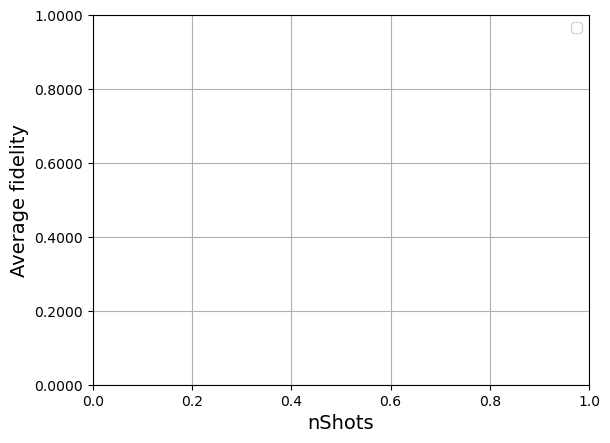

In [ ]:
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots()
shots = []  #[10,25,50,100,500,1000]
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
mValues = [] #[2,3,5]
lineType = ['-','--',':','-.']
expt = 0
for m in mValues:
	fidelityResult= []
	print("m: ",m)
	for nShots in shots:
		print("nShots: ",nShots)
		fAverage = 0
		HHL = myHHL(A,b,lambdaUpper = lambdaUpper, m = m, P0 = P0, nShots = nShots)
		HHL.solveuExact()
		nSuccessfulTrials = 0
		nTrials = 25
		for t in range(nTrials):
			if (not HHL.executeHHL()):
				continue
			nSuccessfulTrials = nSuccessfulTrials +1
			fidelity = np.dot(HHL.uHHL,HHL.uExact)
			fAverage = fAverage + fidelity
		fAverage = fAverage/nSuccessfulTrials
		print("fAverage:", fAverage)
		fidelityResult.append(fAverage)
	
	plt.semilogx(shots, fidelityResult,lineType[expt])
	expt = expt +1

plt.legend(['m=2','m=3','m=5'])
plt.grid(visible = True)
plt.xlabel("nShots", fontsize = 14)
plt.ylabel("Average fidelity", fontsize = 14)



# Chapter 9: VQLS

The Variational Quantum Linear Solver (VQLS) strategy is increasing popular for solving the quantum linear system problem (QLSP)

VQLS Class

In [ ]:
from qiskit.quantum_info import SparsePauliOp
class myVQLS:
	# This is an implementation of the VQLS algorithm described in
	# Bravo-Prieto, C.et.al, 2023. 
	# Variational quantum linear solver. Quantum, 7, p.1188.
	def __init__(self, A, b,nShots = 10000):	
		self.A = A
		self.b = b
		self.nShots = nShots
		self.N = self.A.shape[0]
		self.n = int(np.log2(self.N)) # number of qubits to capture b
		self.CostIterations = []
		if (self.n <=4):
			self.ansatzLayers = self.n-1 # for Ansatz
		else:
			self.ansatzLayers = 4 # for Ansatz
		self.dataOK = True
		self.nAnsatzParams = self.n + self.ansatzLayers*(self.n + self.n-2)
		self.ansatzParams = np.random.rand(self.nAnsatzParams)
		if np.abs(2**self.n - self.A.shape[0]) > 1e-10: 
			print("Invalid size of matrix; must be power of 2") 
			self.dataOK = False

		if (not np.isclose(np.linalg.norm(b), 1.0)):
			print('b does not appear to be of unit magnitude')
			self.dataOK = False
		if not (A.shape[0] == b.shape[0]):
			print('A and b sizes are not compatible')
			self.dataOK = False
			
		self.debug = False
		self.computeUbMatrix()
		self.PauliExpansion()
		
	def solveuExact(self):
		# used for verification and not part of HHL
		xExact = scipy.linalg.solve(self.A, self.b)
		self.uExact = xExact/np.linalg.norm(xExact)
		
	def simulateCircuit(self,circuit,nShots=1000):
		backend = Aer.get_backend('qasm_simulator')
		new_circuit = transpile(circuit, backend)
		job = backend.run(new_circuit,shots = nShots)
		counts = job.result().get_counts(circuit)
		return counts

	def computeUbMatrix(self):
		nQubits = self.n
		u =  QuantumRegister(nQubits, 'u')
		circuit = QuantumCircuit(u)
		circuit.prepare_state(Statevector(self.b) ,u)
		self.UbMatrix = Operator(circuit).data
		
	def PauliExpansion(self):
		pauliSplit = SparsePauliOp.from_operator(self.A)
		self.PauliMatrices = []
		for pauliOp in pauliSplit.paulis:
			PauliMatrix = pauliOp.to_matrix()
			self.PauliMatrices.append(PauliMatrix)	
		self.PauliCoefficients = pauliSplit.coeffs
		self.nPauliTerms = len(self.PauliCoefficients)
		return

	def createAnsatzCircuit(self,addMeasurement = False):
		#  implements Fig 3 of reference paper above
		nQubits = self.n
		u =  QuantumRegister(nQubits, 'u')
		if (addMeasurement):
			c = ClassicalRegister(nQubits,'c')
			circuit = QuantumCircuit(u,c)
		else:
			circuit = QuantumCircuit(u)
		ansatzCounter = 0
		for i in range(nQubits):
			circuit.ry(self.ansatzParams[ansatzCounter], u[i])
			ansatzCounter = ansatzCounter+1 
		circuit.barrier()
		for layer in range(self.ansatzLayers):
			for i in range(0,nQubits-1,2):
				circuit.cz(u[i], u[i+1])
			for i in range(nQubits):
				circuit.ry(self.ansatzParams[ansatzCounter], u[i])
				ansatzCounter = ansatzCounter+1 
			for i in range(1,nQubits-1,2):
				circuit.cz(u[i], u[i+1])
			for i in range(1,nQubits-1,1):
				circuit.ry(self.ansatzParams[ansatzCounter], u[i])
				ansatzCounter = ansatzCounter+1 	
			circuit.barrier()
		
		if (addMeasurement):
			circuit.measure(u, c)
		return circuit

	def HadamardTestCircuit1(self,UthetaMatrix, PjMatrix,UbMatrix,imagComponent = False):
		nQubits = self.n
		a = QuantumRegister(1, 'a')
		u =  QuantumRegister(nQubits, '0')
		c = ClassicalRegister(1,'c')
		circuit = QuantumCircuit(a,u,c)
		circuit.h(0)
		if (imagComponent):
			circuit.sdg(0)

		U = UnitaryGate(np.matmul(np.matmul(UbMatrix.conj().T,PjMatrix),UthetaMatrix))
		U._name = r'$ U_{\theta}$'
		UControl = U.control(1)
		circuit.append(UControl,[*range(self.n+1)])

		circuit.h(0)
		circuit.measure([0], [0])
		return circuit


	def HadamardTestCircuit2(self,UthetaMatrix, PjMatrix,PkMatrix,imagComponent = False):
		nQubits = self.n
		u =  QuantumRegister(nQubits, '0')
		a = QuantumRegister(1, 'a')
		c = ClassicalRegister(1,'c')
		circuit = QuantumCircuit(a,u,c)
		circuit.h(0)
		UTheta = UnitaryGate(UthetaMatrix)
		UTheta._name = r'$ U_{\theta}$'
		circuit.append(UTheta, [*range(1,self.n+1)])
		if (imagComponent):
			circuit.sdg(0)
		
		UPj = UnitaryGate(PjMatrix).adjoint()
		UPj._name = r'$ U_{P_j}^{\dag}$'
		UPjControl = UPj.control(1)
		circuit.append(UPjControl, [*range(self.n+1)])
		UPk = UnitaryGate(PkMatrix)
		UPk._name = r'$ U_{P_k}$'
		UPkControl = UPk.control(1)
		circuit.append(UPkControl, [*range(self.n+1)])
		circuit.h(0)
		circuit.measure([0], [0])
		return circuit
		
	def costFunctionExact(self,thetaParams):
		self.ansatzParams = thetaParams.copy()
		self.ansatzCircuit = self.createAnsatzCircuit()
		UTheta = Operator(self.ansatzCircuit).data
		zeroQubit = np.zeros(2**self.n)
		zeroQubit[0] = 1
		u = np.matmul(UTheta,zeroQubit)
		phi =  np.matmul(self.A,u)
		numerator = (np.matmul(self.b,phi))**2
		denominator = np.matmul(phi,phi)
		CG  = 1 - np.real(numerator/denominator)
		self.CostIterations.append(CG)
		return CG
	
	def costFunction(self,thetaParams):
		gReal = np.zeros(self.nPauliTerms)
		gImag = np.zeros(self.nPauliTerms)
		self.ansatzParams = thetaParams.copy()
		self.ansatzCircuit = self.createAnsatzCircuit()
		self.ansatzMatrix = Operator(self.ansatzCircuit).data
		for j in range(self.nPauliTerms):
			circ1Real = self.HadamardTestCircuit1(self.ansatzMatrix,
										   self.PauliMatrices[j],self.UbMatrix)
			counts = self.simulateCircuit(circ1Real,self.nShots)
			gReal[j] = (counts.get('0', 0)- counts.get('1', 0))/self.nShots
			circ1Imag = self.HadamardTestCircuit1(self.ansatzMatrix,
										   self.PauliMatrices[j],self.UbMatrix,True)
			counts = self.simulateCircuit(circ1Imag,self.nShots)
			gImag[j] = (counts.get('0', 0)- counts.get('1', 0))/self.nShots
		
		numerator = 0
		for j in range(self.nPauliTerms):
			aj = self.PauliCoefficients[j]
			numerator = numerator + aj*(gReal[j]+1j*gImag[j])
		
		numerator = (numerator)**2
		hReal = np.zeros((self.nPauliTerms,self.nPauliTerms))
		hImag =  np.zeros((self.nPauliTerms,self.nPauliTerms))
		for j in range(self.nPauliTerms):
			for k in range(self.nPauliTerms):
				circ2Real = self.HadamardTestCircuit2(self.ansatzMatrix, self.PauliMatrices[j],self.PauliMatrices[k])
				counts = self.simulateCircuit(circ2Real,self.nShots)
				hReal[j][k] = (counts.get('0', 0)- counts.get('1', 0))/self.nShots
				
				circ2Imag = self.HadamardTestCircuit2(self.ansatzMatrix, self.PauliMatrices[j],self.PauliMatrices[k],True)
				counts =  self.simulateCircuit(circ2Imag,self.nShots)
				hImag[j][k] = (counts.get('0', 0)- counts.get('1', 0))/self.nShots
				
		denominator = 0
		for j in range(self.nPauliTerms):
			aj = self.PauliCoefficients[j]
			for k in range(self.nPauliTerms):
				ak = self.PauliCoefficients[k]
				denominator = denominator + aj*ak*(hReal[j][k]+1j*hImag[j][k])

		CG  = 1 - np.real(numerator/denominator)
		self.CostIterations.append(CG)
		return CG
	
	def plotCostFunction(self,nSamples = 33):
		if (self.n > 1):
			print('plotCostFunction is only valid for 1 qubit')
			return False
		if not self.dataOK:
			print('Check input data')
			return False
		thetaParams = np.zeros(self.nAnsatzParams)
		thetaValues = np.linspace(0,2*np.pi,nSamples)
		CGValues = []
		for theta in thetaValues:
			thetaParams[0] = theta
			CG = np.real(self.costFunction(thetaParams))
			CGValues.append(CG)
		plt.plot(thetaValues,CGValues)
		plt.xlabel(r'$\theta$')
		plt.ylabel(r'$C_G$')
		plt.grid(True)
	def executeVQLS(self):
		if not self.dataOK:
			print('Check input data')
			return False

		self.CostIterations = []
		thetaParams = np.random.rand(self.nAnsatzParams)
		result = scipy.optimize.minimize(self.costFunction,
								   thetaParams, method='COBYLA' )
		
		self.minCG = result['fun']
		self.thetaOptimal = result['x']
		self.ansatzParams = self.thetaOptimal.copy()
		self.ansatzCircuit = self.createAnsatzCircuit(True)
		counts = self.simulateCircuit(self.ansatzCircuit,self.nShots)
		self.uVQLS = 0
		for key in counts:
			v = np.real(Statevector.from_label(key)) # extract v 
			self.uVQLS = self.uVQLS + v*np.sqrt(counts[key]/self.nShots)


## VQLS Examples

In [ ]:
from scipy.sparse import diags

example = 1
if (example == 1):
	A = np.array([[1,0],[0,0.75]]) 
	b = np.array([0,1])
elif (example == 2):
	A = np.array([[2,-1],[-1,2]])
	b = np.array([1,1])/np.sqrt(2)
elif (example == 3):
	A = np.array([[1,0,0,-0.5],[0,1,0,0],[0,0,1,0],[-0.5,0,0,1]])
	b = np.array([1,0,0,0])
elif (example == 4):
	A = np.array([[1.5,0.5],[0.5,1.5]])
	b = np.array([1,0])
elif (example == 5):
	p = 2
	A = np.array([[5*(10**p),-1],[-1,5]])
	b = np.array([1,0])
elif (example == 6):
	N = 4
	values = [-np.ones(N-1),2*np.ones(N),-np.ones(N-1)]
	A = diags(values,[-1,0,1]).toarray()
	b = np.zeros(N)
	b[0] = 1

print("A:\n", A)
print("b:\n", b)

A:
 [[1.   0.  ]
 [0.   0.75]]
b:
 [0 1]


## VQLS Execution

Exact sol: [0. 1.]
------------------------------
Min Cost:  0.0005775456577717941
Optimal theta:  [3.07]
VQLS  sol: [0.032 0.999]


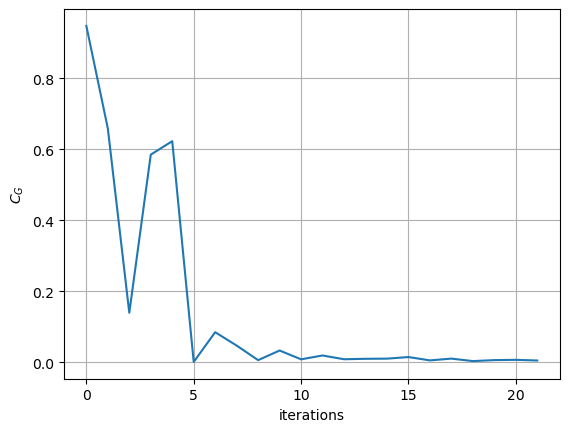

In [ ]:
nShots = 1000
vqls = myVQLS(A, b,nShots)

vqls.solveuExact()
print('Exact sol:',vqls.uExact)
vqls.executeVQLS()
plt.plot(vqls.CostIterations)
plt.xlabel(r'iterations')
plt.ylabel(r'$C_G$')
plt.grid(True)
print("------------------------------")
print('Min Cost: ', vqls.minCG)
print('Optimal theta: ', vqls.thetaOptimal)
print('VQLS  sol:',vqls.uVQLS)

# Engineering Applications

## Homogenization 